# Section 1: Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
    import hdbscan
    from kmodes.kprototypes import KPrototypes
    from sentence_transformers import SentenceTransformer
except ImportError:
    print("Some advanced packages are not installed. You may need to install them with pip.")

# Section 2: Data Loading and Initial Exploration

In [3]:
# Dataset
df_original = pd.read_csv('shopping_behavior_updated.csv')
df = df_original.copy()  # Create a working copy of the original data

# First few rows
print(df.head())

   Customer ID  Age Gender Item Purchased  Category  Purchase Amount (USD)  \
0            1   55   Male         Blouse  Clothing                     53   
1            2   19   Male        Sweater  Clothing                     64   
2            3   50   Male          Jeans  Clothing                     73   
3            4   21   Male        Sandals  Footwear                     90   
4            5   45   Male         Blouse  Clothing                     49   

        Location Size      Color  Season  Review Rating Subscription Status  \
0       Kentucky    L       Gray  Winter            3.1                 Yes   
1          Maine    L     Maroon  Winter            3.1                 Yes   
2  Massachusetts    S     Maroon  Spring            3.1                 Yes   
3   Rhode Island    M     Maroon  Spring            3.5                 Yes   
4         Oregon    M  Turquoise  Spring            2.7                 Yes   

   Shipping Type Discount Applied Promo Code Used  Previ

In [4]:
# Basic information
print(df.info())

# Descriptive statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Customer ID             3900 non-null   int64  
 1   Age                     3900 non-null   int64  
 2   Gender                  3900 non-null   object 
 3   Item Purchased          3900 non-null   object 
 4   Category                3900 non-null   object 
 5   Purchase Amount (USD)   3900 non-null   int64  
 6   Location                3900 non-null   object 
 7   Size                    3900 non-null   object 
 8   Color                   3900 non-null   object 
 9   Season                  3900 non-null   object 
 10  Review Rating           3900 non-null   float64
 11  Subscription Status     3900 non-null   object 
 12  Shipping Type           3900 non-null   object 
 13  Discount Applied        3900 non-null   object 
 14  Promo Code Used         3900 non-null   

# Section 3: Common Feature Engineering (Base Transformations)

Some features can be/need to be converted to numerical values, so we do that here. We want to be able to cluster customers by Recency, Frequency, and Monetary characteristics. For lack of a better way to interpret time, we use the number of previous purchases as how recently a customer has purchased something with higher values corresponding to more recent purchaes. Frequency has already been provided but in categorical form which is convertible to numeric form. Monetary is also already given. We also create a new feature - Engagement - that combines the three values.

In [5]:
# Mapping categorical frequencies to numerical values
frequency_mapping = {
    "Weekly": 52,
    "Fortnightly": 26,
    "Bi-Weekly": 24,
    "Monthly": 12,
    "Every 3 Months": 4,
    "Quarterly": 4,
    "Annually": 1
}

# New column with numeric frequency values
df["Frequency of Purchases (Numeric)"] = df["Frequency of Purchases"].map(frequency_mapping)

# RFM base features that all models will need
df['Recency'] = df['Previous Purchases']
df['Frequency'] = df['Frequency of Purchases (Numeric)']
df['Monetary'] = df['Purchase Amount (USD)']

# Engagement Score based on review rating
if "Review Rating" in df.columns:
    df["Engagement_Score"] = df["Review Rating"]
else:
    df["Engagement_Score"] = 0  # Default if missing

# Binary subscription status
df["Subscription Status"] = df["Subscription Status"].str.lower().str.strip()
df["Subscription_Status_Binary"] = df["Subscription Status"].apply(lambda x: 1 if x == "yes" else 0)

# Loyalty Score as a combination of metrics
df["Loyalty_Score"] = df["Frequency"] + df["Recency"] + (df["Subscription_Status_Binary"] * 10)

# Original DataFrame with basic feature engineering for future models
df_base = df.copy()

In [6]:
# Range of values for each of the RFM feature
print("Recency:", df['Recency'].min(), df['Recency'].max())
print("Frequency:", df['Frequency'].min(), df['Frequency'].max())
print("Monetary:", df['Monetary'].min(), df['Monetary'].max())
print("Engagement Score:", df['Engagement_Score'].min(), df['Engagement_Score'].max())
print("Loyalty Score:", df['Loyalty_Score'].min(), df['Loyalty_Score'].max())


Recency: 1 50
Frequency: 1 52
Monetary: 20 100
Engagement Score: 2.5 5.0
Loyalty Score: 2 112


*Recency: 1-50*

Scale: Days since last purchase

Interpretation: 1 = purchased yesterday, 50 = purchased ~7 weeks ago

Lower values indicate more recent customers who are currently active.

*Frequency: 1-52*

Scale: Number of purchases in the tracking period

Interpretation: 1 = one-time buyer, 52 = weekly shopper (approximately)

Higher values represent regular, repeat customers.

*Monetary: 20-100*

Scale: Average spend in currency units (likely dollars)

Interpretation: 20 = low-value purchases, 100 = high-value purchases

Higher values represent customers who spend more per transaction.

*Engagement Score: 2.5-5.0*

Scale: Composite metric on a 5-point scale

Interpretation: 2.5 = minimal engagement, 5.0 = maximum engagement

Higher values reflect customers who interact more with emails, website, app, etc.

*Loyalty Score: 2-102*

Scale: Composite metric combining other factors

Interpretation: 2 = new or infrequent customer, 102 = highly loyal customer

Higher values identify the most valuable long-term customers.


# Section 4: K-means Clustering Analysis

We first try KMeans on the RFM metrics that we just engineered, since these are now all numeric. We find an elbow at k=5 and decide to move forward with that many clusters. We get a silhouette score of 0.3147, which is okay.

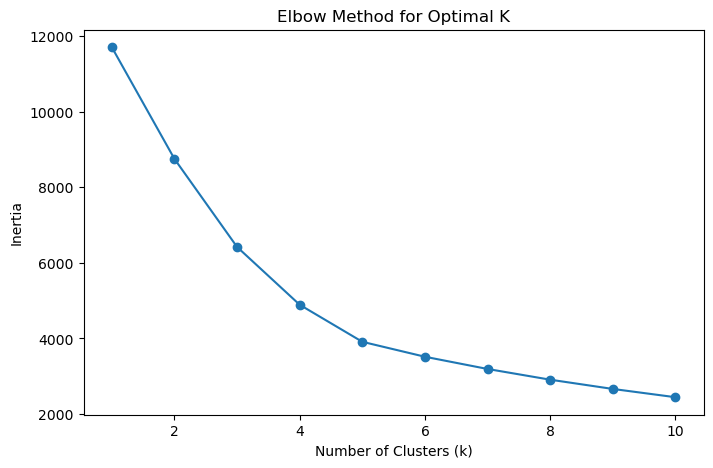

Cluster means (scaled features):
                 Recency  Frequency  Monetary
KMeans_Cluster                               
0               0.029093   2.087009 -0.033451
1              -0.848697  -0.334167 -0.877035
2               0.852992  -0.343670 -0.877307
3               0.890113  -0.326187  0.872300
4              -0.863387  -0.335100  0.861021
Silhouette Score: 0.3147
Davies-Bouldin Index: 0.9893
Inertia (WCSS): 3910.6439


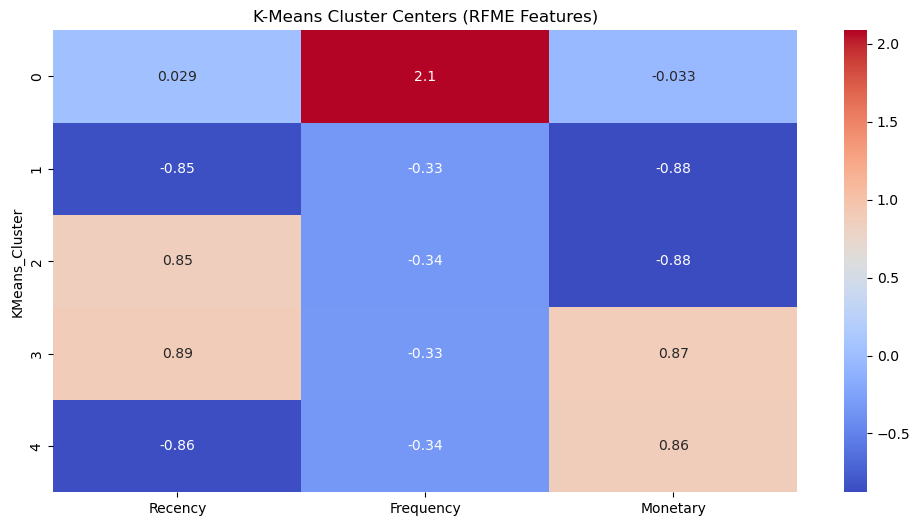

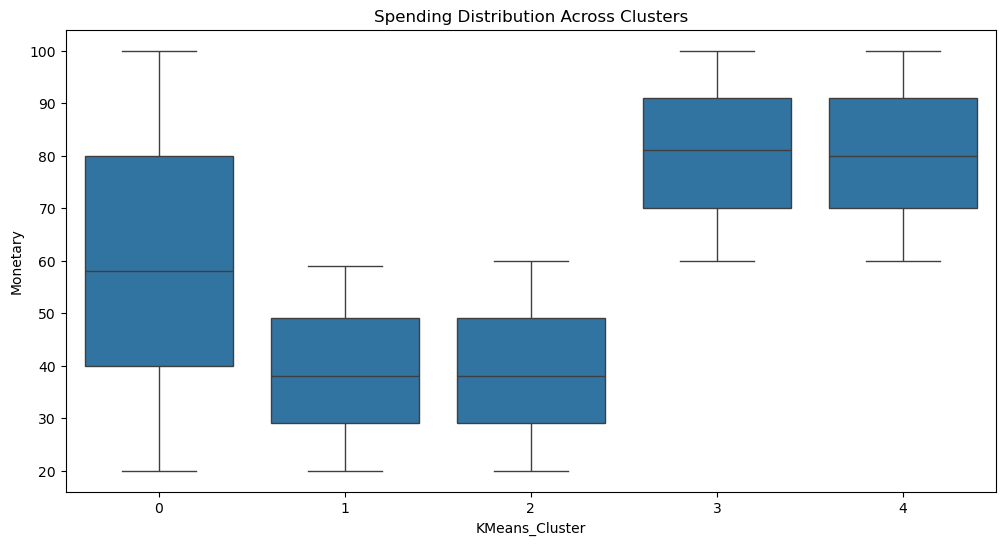


K-Means Cluster Profiles:
   KMeans_Cluster    Recency  Frequency   Monetary  Loyalty_Score  \
0               0  25.771800  52.000000  58.972171      80.684601   
1               1  13.091873  11.617197  38.994111      27.170789   
2               2  37.673243  11.458693  38.987670      52.066584   
3               3  38.209467  11.750296  80.422485      52.598817   
4               4  12.879673  11.601636  80.155374      27.121495   

   Engagement_Score                                            Persona  
0          3.759555  High-Value Loyal Customer (High monetary spend...  
1          3.713310  Recent Engaged Shopper (Good engagement score ...  
2          3.711837  Frequent Low-Spender (High frequency but low m...  
3          3.782485  Infrequent Low-Spender (Low frequency and low ...  
4          3.784229  Dormant High-Value Customer (High recency, mea...  


In [7]:
# Separate copy for K-means modeling
df_kmeans = df_base.copy()

# Feature preparation for K-means. Categorical variables to lowercase for consistency
categorical_cols = ['Gender', 'Category']
for col in categorical_cols:
    if col in df_kmeans.columns:
        df_kmeans[col] = df_kmeans[col].str.lower().str.strip()

# Feature selection and standardization for K-means
features_for_kmeans = ['Recency', 'Frequency', 'Monetary']
scaler_kmeans = StandardScaler()
df_kmeans_scaled = scaler_kmeans.fit_transform(df_kmeans[features_for_kmeans])

# Optimal K using Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(df_kmeans_scaled)
    inertia.append(kmeans.inertia_)

# Plot 
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()

# K-means with optimal k
optimal_k = 5  # Identified from elbow plot
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(df_kmeans_scaled)

# Cluster labels to the dataframe
df_kmeans["KMeans_Cluster"] = cluster_labels

# Analysis of K-means Clusters
# DataFrame with scaled features for analysis
df_kmeans_analysis = pd.DataFrame(df_kmeans_scaled, columns=features_for_kmeans)
df_kmeans_analysis["KMeans_Cluster"] = cluster_labels

# Calculating cluster means
cluster_means = df_kmeans_analysis.groupby("KMeans_Cluster").mean()
print("Cluster means (scaled features):")
print(cluster_means)

# Evaluation metrics
silhouette = silhouette_score(df_kmeans_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(df_kmeans_scaled, cluster_labels)
inertia_final = kmeans_model.inertia_

print(f"Silhouette Score: {silhouette:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"Inertia (WCSS): {inertia_final:.4f}")

# Cluster characteristics
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means, annot=True, cmap="coolwarm")
plt.title("K-Means Cluster Centers (RFME Features)")
plt.show()

# Distribution of spending by cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x="KMeans_Cluster", y="Monetary", data=df_kmeans)
plt.title("Spending Distribution Across Clusters")
plt.show()

# Cluster Profiling, defining personas based on cluster characteristics
kmeans_personas = {
    0: "High-Value Loyal Customer (High monetary spend with consistent frequency)",
    1: "Recent Engaged Shopper (Good engagement score with recent purchases)",
    2: "Frequent Low-Spender (High frequency but low monetary value per transaction)",
    3: "Infrequent Low-Spender (Low frequency and low monetary value)",
    4: "Dormant High-Value Customer (High recency, meaning they haven't purchased in a while)"
}

df_kmeans["KMeans_Persona"] = df_kmeans["KMeans_Cluster"].map(kmeans_personas)

# Summarize profiles with labels
cluster_profiles_kmeans = df_kmeans.groupby("KMeans_Cluster")[features_for_kmeans + ["Loyalty_Score", "Engagement_Score"]].mean().reset_index()
cluster_profiles_kmeans["Persona"] = cluster_profiles_kmeans["KMeans_Cluster"].map(kmeans_personas)

print("\nK-Means Cluster Profiles:")
print(cluster_profiles_kmeans)


# Section 5: Hierarchical Clustering Analysis

We also try hierarchical clustering on the same RFM metrics and find a slightly worse silhouette score of 0.2619.

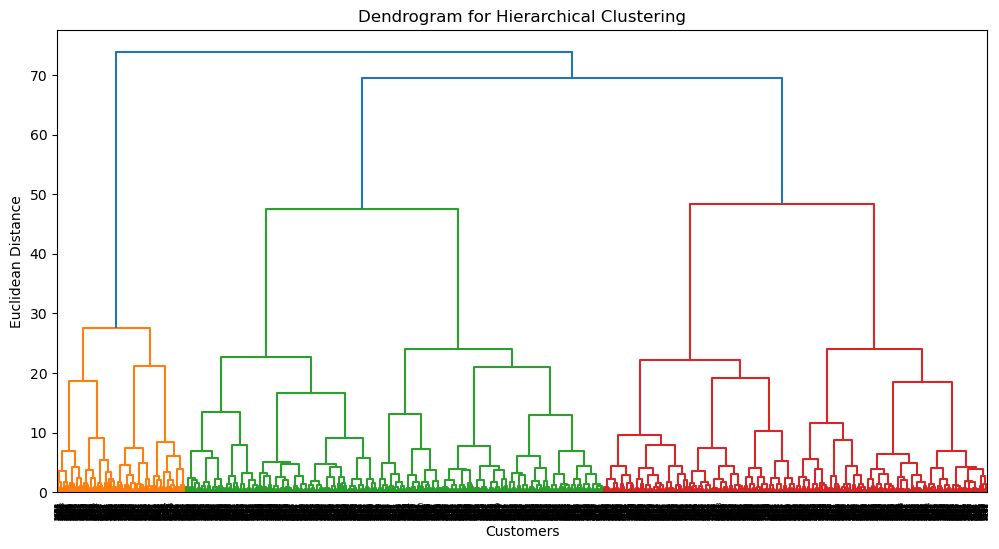

Silhouette Score (Hierarchical): 0.2619
Davies-Bouldin Index (Hierarchical): 1.0958

Hierarchical Clustering - Cluster Summary:
                      Customer ID        Age  Purchase Amount (USD)  \
Hierarchical_Cluster                                                  
0                     1945.623362  43.951567              41.274644   
1                     1911.705009  44.649351              58.972171   
2                     1942.066085  44.099751              74.965087   
3                     1995.565920  43.902985              85.492537   

                      Review Rating  Previous Purchases  \
Hierarchical_Cluster                                      
0                          3.727464           22.444444   
1                          3.759555           25.771800   
2                          3.773317           40.286783   
3                          3.769279           16.517413   

                      Frequency of Purchases (Numeric)    Recency  Frequency  \
Hierarchic

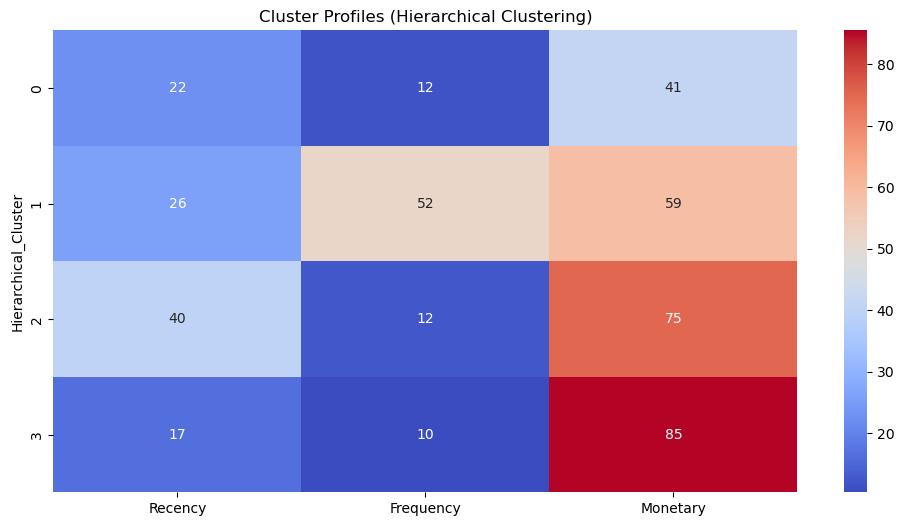

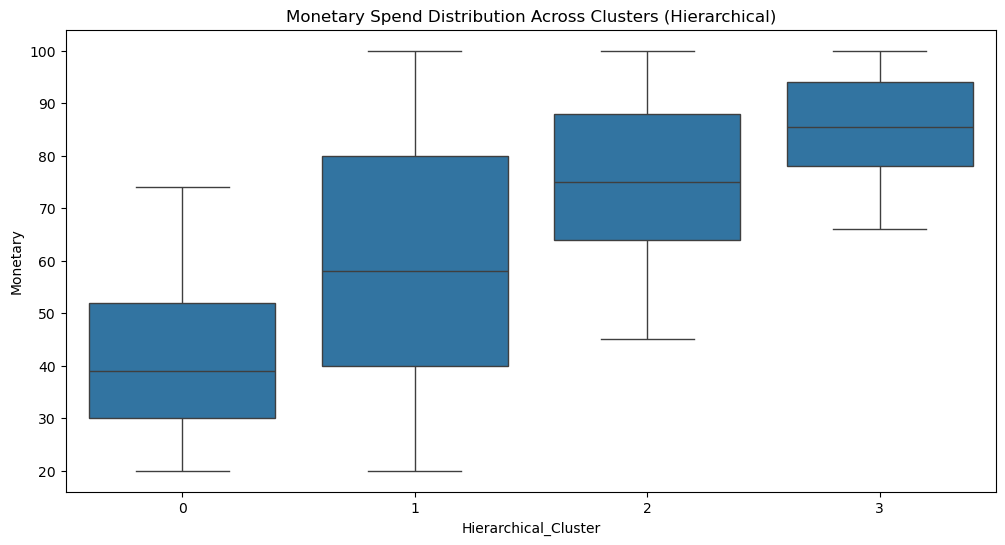


Hierarchical Clustering - Customer Personas:
   Hierarchical_Cluster    Recency  Frequency   Monetary  \
0                     0  22.444444  11.807977  41.274644   
1                     1  25.771800  52.000000  58.972171   
2                     2  40.286783  12.375312  74.965087   
3                     3  16.517413  10.407960  85.492537   

                                             Persona  
0  Premium Shopper (High spending and good freque...  
1  Occasional Buyer (They spend less per transact...  
2  At-Risk Customer (Low engagement, low monetary...  
3  High-Frequency Budget Shopper(Very high freque...  


In [8]:
# Separate copy for hierarchical clustering
df_hierarchical = df_base.copy()

# Feature selection for hierarchical clustering 
features_hierarchical = ['Recency', 'Frequency', 'Monetary']

# Feature scaling
scaler_hierarchical = StandardScaler()
df_hierarchical_scaled = scaler_hierarchical.fit_transform(df_hierarchical[features_hierarchical])

# Dendrogram to determine the number of clusters
plt.figure(figsize=(12, 6))
dendrogram = sch.dendrogram(sch.linkage(df_hierarchical_scaled, method="ward"))
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Customers")
plt.ylabel("Euclidean Distance")
plt.show()

# Number of clusters based on the dendrogram
n_clusters_hierarchical = 4 

# Agglomerative Clustering
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters_hierarchical, metric="euclidean", linkage="ward")
df_hierarchical["Hierarchical_Cluster"] = agg_clustering.fit_predict(df_hierarchical_scaled)

# Evaluating the clustering
silhouette_hierarchical = silhouette_score(df_hierarchical_scaled, df_hierarchical["Hierarchical_Cluster"])
davies_bouldin_hierarchical = davies_bouldin_score(df_hierarchical_scaled, df_hierarchical["Hierarchical_Cluster"])

# Clustering metrics
print(f"Silhouette Score (Hierarchical): {silhouette_hierarchical:.4f}")
print(f"Davies-Bouldin Index (Hierarchical): {davies_bouldin_hierarchical:.4f}")

# Cluster distribution
numeric_columns = df_hierarchical.select_dtypes(include=[np.number]).columns
print("\nHierarchical Clustering - Cluster Summary:")
print(df_hierarchical.groupby("Hierarchical_Cluster")[numeric_columns].mean())

# Visualizing cluster characteristics
cluster_means_hierarchical = df_hierarchical.groupby("Hierarchical_Cluster")[features_hierarchical].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_means_hierarchical, annot=True, cmap="coolwarm")
plt.title("Cluster Profiles (Hierarchical Clustering)")
plt.show()

# Distribution of spending by cluster
plt.figure(figsize=(12, 6))
sns.boxplot(x="Hierarchical_Cluster", y="Monetary", data=df_hierarchical)
plt.title("Monetary Spend Distribution Across Clusters (Hierarchical)")
plt.show()

# Defining personas based on cluster behaviors
hierarchical_personas = {
    0: "Premium Shopper (High spending and good frequency, indicating premium buyers.)",
    1: "Occasional Buyer (They spend less per transaction and have high recency, meaning they haven't purchased recently but may return occasionally.)",
    2: "At-Risk Customer (Low engagement, low monetary spend, and moderate frequency. At risk of churning soon.)",
    3: "High-Frequency Budget Shopper(Very high frequency, but moderate spending. They buy often but prioritize affordability over premium products.)"
}

df_hierarchical["Hierarchical_Persona"] = df_hierarchical["Hierarchical_Cluster"].map(hierarchical_personas)

# Summarize profiles
cluster_profiles_hierarchical = df_hierarchical.groupby("Hierarchical_Cluster")[features_hierarchical].mean().reset_index()
cluster_profiles_hierarchical["Persona"] = cluster_profiles_hierarchical["Hierarchical_Cluster"].map(hierarchical_personas)

print("\nHierarchical Clustering - Customer Personas:")
print(cluster_profiles_hierarchical)


# Section 6: DBSCAN (Density-Based Clustering)

DBSCAN on the same RFM metrics return 0.1924, which is pretty poor, even after fine tuning with hyperparameters."

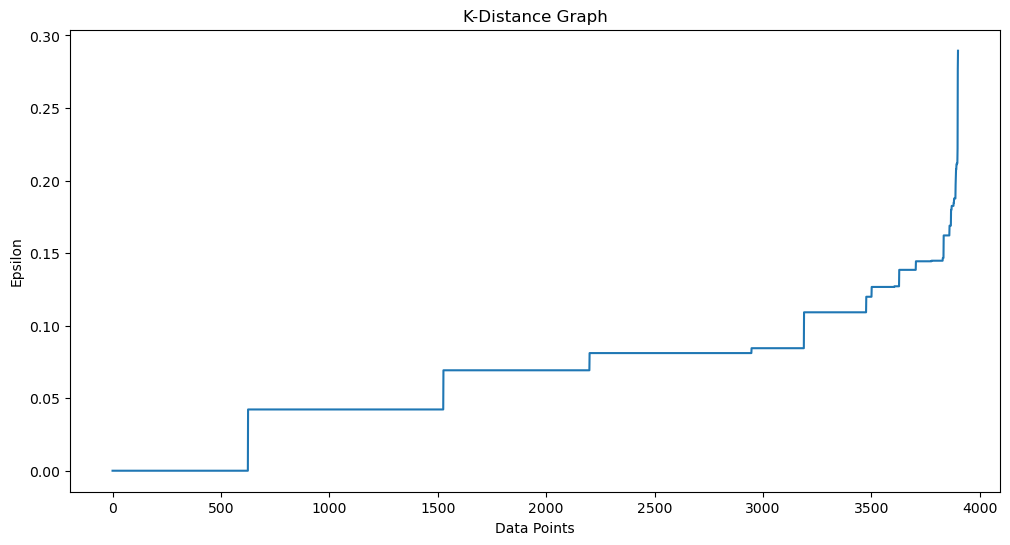


DBSCAN Parameter Tuning Results:
Parameters: (0.58, 5) - Clusters: 3, Noise Points: 0
Parameters: (0.58, 8) - Clusters: 3, Noise Points: 0
Parameters: (0.58, 10) - Clusters: 3, Noise Points: 0
Parameters: (0.6, 5) - Clusters: 3, Noise Points: 0
Parameters: (0.6, 8) - Clusters: 3, Noise Points: 0
Parameters: (0.6, 10) - Clusters: 3, Noise Points: 0
Parameters: (0.62, 5) - Clusters: 3, Noise Points: 0
Parameters: (0.62, 8) - Clusters: 3, Noise Points: 0
Parameters: (0.62, 10) - Clusters: 3, Noise Points: 0

DBSCAN Clustering Results:
Cluster Distribution:
 DBSCAN_Cluster
2    2272
0    1089
1     539
Name: count, dtype: int64

Number of Outliers Detected: 0

Silhouette Score for DBSCAN: 0.1924


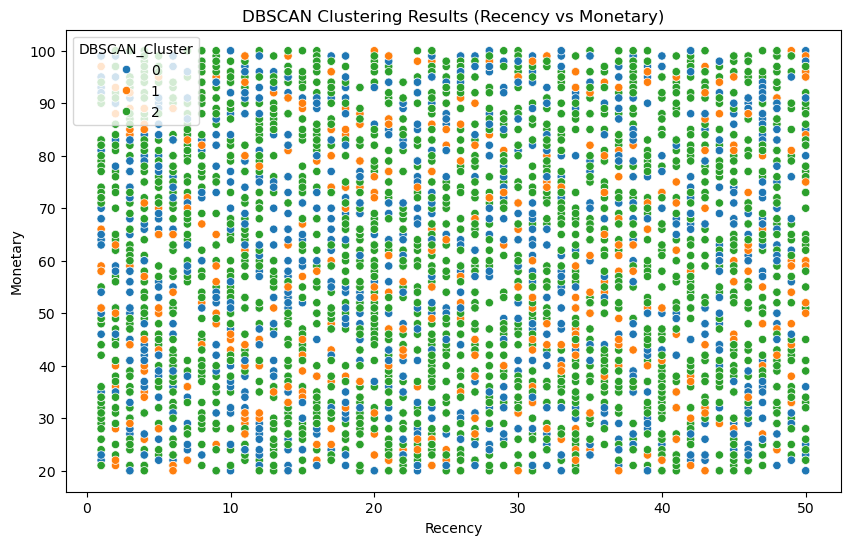


DBSCAN Customer Personas:
   DBSCAN_Cluster    Recency  Frequency   Monetary  \
0               0  25.028466  24.995409  59.877870   
1               1  25.771800  52.000000  58.972171   
2               2  25.406690   5.191901  59.897887   

                                             Persona  
0  Premium Loyalist (High monetary value, moderat...  
1  High-Frequency Deal Seeker (This group buys ve...  
2  Low-Value Irregular Shopper (They have low spe...  


In [9]:
# Separate copy for DBSCAN clustering
df_dbscan = df_base.copy()

# Feature selection for DBSCAN
features_dbscan = ['Recency', 'Frequency', 'Monetary']

# Feature scaling using StandardScaler
scaler_dbscan = StandardScaler()
df_dbscan_scaled = scaler_dbscan.fit_transform(df_dbscan[features_dbscan])

# K-distance graph to determine epsilon
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(df_dbscan_scaled)
distances, indices = neighbors_fit.kneighbors(df_dbscan_scaled)

# Distances
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.figure(figsize=(12, 6))
plt.plot(distances)
plt.title("K-Distance Graph")
plt.xlabel("Data Points")
plt.ylabel("Epsilon")
plt.show()

# Fine-tuning around best found parameters 
eps_values = [0.58, 0.6, 0.62]  
min_samples_values = [5, 8, 10]  

dbscan_optimized_results = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(df_dbscan_scaled)
        num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        num_noise = list(clusters).count(-1)

        # Silhouette Score
        if num_clusters > 1:
            silhouette = silhouette_score(df_dbscan_scaled, clusters)
        else:
            silhouette = None

        dbscan_optimized_results[(eps, min_samples)] = {
            "Number of Clusters": num_clusters,
            "Noise Points": num_noise,
            "Silhouette Score": silhouette
        }

# DBSCAN parameter tuning results
print("\nDBSCAN Parameter Tuning Results:")
for params, results in dbscan_optimized_results.items():
    print(f"Parameters: {params} - Clusters: {results['Number of Clusters']}, Noise Points: {results['Noise Points']}")

# DBSCAN with optimal parameters    
optimal_eps = 0.62
optimal_min_samples = 5
dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)

# Add cluster labels
df_dbscan["DBSCAN_Cluster"] = dbscan.fit_predict(df_dbscan_scaled)

# Count clusters and noise points (-1 indicates noise)
cluster_counts = df_dbscan["DBSCAN_Cluster"].value_counts()
outliers_count = cluster_counts[-1] if -1 in cluster_counts else 0

# Results
print("\nDBSCAN Clustering Results:")
print("Cluster Distribution:\n", cluster_counts)
print("\nNumber of Outliers Detected:", outliers_count)

# Evaluate DBSCAN clustering excluding noise points
filtered_df_dbscan = df_dbscan[df_dbscan["DBSCAN_Cluster"] != -1]
filtered_scaled_dbscan = df_dbscan_scaled[df_dbscan["DBSCAN_Cluster"] != -1]

# Silhouette score
if len(set(filtered_df_dbscan["DBSCAN_Cluster"])) > 1:
    silhouette_dbscan = silhouette_score(filtered_scaled_dbscan, filtered_df_dbscan["DBSCAN_Cluster"])
    print(f"\nSilhouette Score for DBSCAN: {silhouette_dbscan:.4f}")
else:
    silhouette_dbscan = None
    print("\nSilhouette Score not available (DBSCAN found only one cluster).")

# DBSCAN clustering results
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_dbscan["Recency"], y=df_dbscan["Monetary"], hue=df_dbscan["DBSCAN_Cluster"], palette="tab10")
plt.title("DBSCAN Clustering Results (Recency vs Monetary)")
plt.show()

# Personas for DBSCAN clusters
dbscan_personas = {
    -1: "Noise/Outliers (Unique customer behaviors that don't fit standard patterns)",
    0: "Premium Loyalist (High monetary value, moderate frequency, and high engagement.)",
    1: "High-Frequency Deal Seeker (This group buys very frequently but spends moderately, likely prioritizing discounts and promotions.)",
    2: "Low-Value Irregular Shopper (They have low spending, low frequency, and are not very engaged, meaning they shop infrequently and don't interact much.)"
}


df_dbscan["DBSCAN_Persona"] = df_dbscan["DBSCAN_Cluster"].map(dbscan_personas)

# Profile summary with persona labels
dbscan_profiles = df_dbscan.groupby("DBSCAN_Cluster")[features_dbscan].mean().reset_index()
dbscan_profiles["Persona"] = dbscan_profiles["DBSCAN_Cluster"].map(dbscan_personas)

print("\nDBSCAN Customer Personas:")
print(dbscan_profiles)

# Section 7: RFME Analysis (Recency, Frequency, Monetary, Engagement)

Now, we add in the Engagement feature and try running KMeans. This model ends up doing worse (SS: 0.2246) than the original RFM KMeans but better than RFM DBSCAN.


RFME Features (Normalized):
    Recency  Frequency  Monetary  Engagement_Score
0  0.265306   0.490196    0.4125              0.24
1  0.020408   0.490196    0.5500              0.24
2  0.448980   1.000000    0.6625              0.24
3  0.979592   1.000000    0.8750              0.40
4  0.612245   0.000000    0.3625              0.08


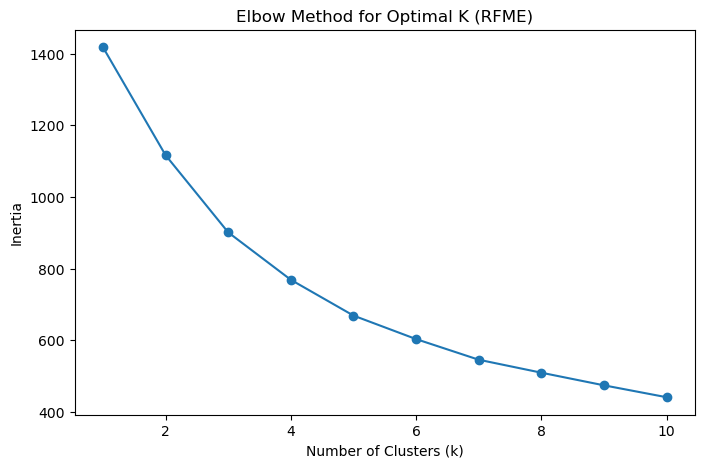


RFME Clustering Evaluation:
Silhouette Score: 0.2246
Davies-Bouldin Index: 1.2307


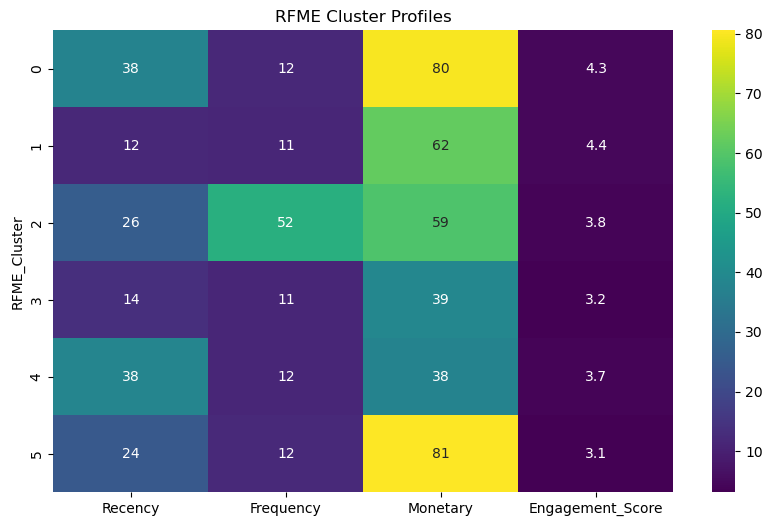


RFME Cluster Summary:
   RFME_Cluster    Recency  Frequency   Monetary  Engagement_Score  \
0             0  37.868243  11.608108  79.815878          4.329392   
1             1  11.694405  11.319943  61.969871          4.427260   
2             2  25.771800  52.000000  58.972171          3.759555   
3             3  13.551020  11.457483  38.957483          3.222449   
4             4  38.305292  11.502035  37.633650          3.716147   
5             5  24.380187  12.101740  80.599732          3.100402   

                                             Persona  
0  High-Value Loyal Customer (High monetary spend...  
1  Recent Engaged Shopper (High engagement score ...  
2  Frequent Low-Spender (Extremely high frequency...  
3  Infrequent Low-Spender (Low monetary and moder...  
4  Dormant High-Value Customer (High recency (mea...  
5  High-Frequency Premium Buyer (High frequency a...  


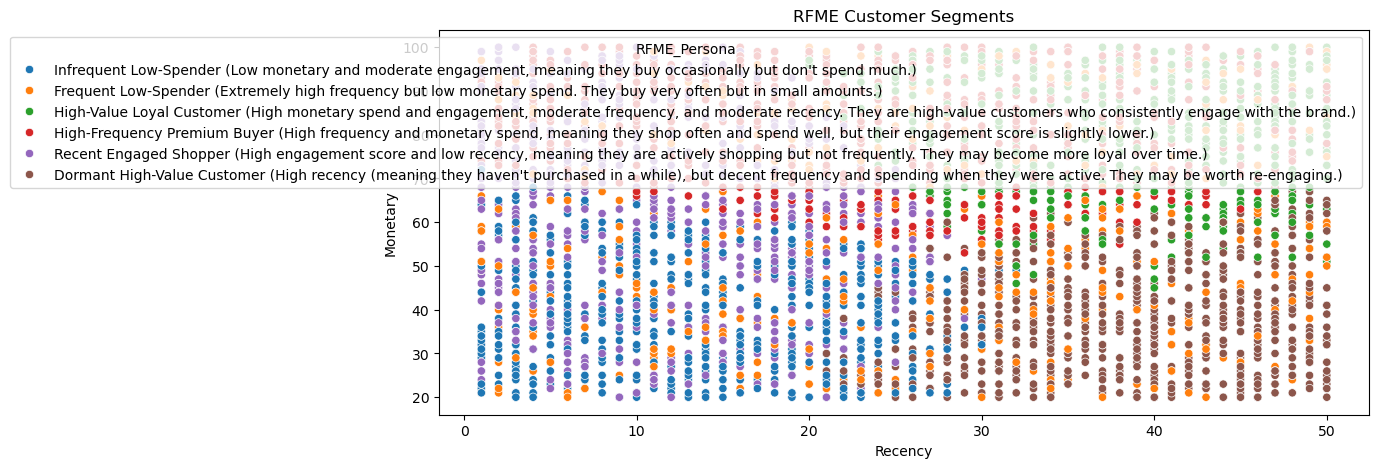

In [10]:
# Copy for RFME analysis
df_rfme = df_base.copy()

# Feature selection for RFME model
rfme_features = ["Recency", "Frequency", "Monetary", "Engagement_Score"]

# Normalizing the RFME features knowing min-max scaling is good for this analysis
scaler_rfme = MinMaxScaler()
rfme_scaled_array = scaler_rfme.fit_transform(df_rfme[rfme_features])
df_rfme_scaled = pd.DataFrame(rfme_scaled_array, columns=rfme_features)

print("\nRFME Features (Normalized):")
print(df_rfme_scaled.head())

# K-means for RFME Clustering
# Elbow Method to determine optimal K
inertia_rfme = []
for k in range(1, 11):
    kmeans_rfme = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_rfme.fit(df_rfme_scaled)
    inertia_rfme.append(kmeans_rfme.inertia_)

# Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia_rfme, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K (RFME)")
plt.show()

# Optimal RFME clustering (6 clusters based on visualization)
optimal_k_rfme = 6
kmeans_rfme = KMeans(n_clusters=optimal_k_rfme, random_state=42, n_init=10)
df_rfme["RFME_Cluster"] = kmeans_rfme.fit_predict(df_rfme_scaled)

# Evaluate RFME clustering
silhouette_rfme = silhouette_score(df_rfme_scaled, df_rfme["RFME_Cluster"])
davies_bouldin_rfme = davies_bouldin_score(df_rfme_scaled, df_rfme["RFME_Cluster"])

print("\nRFME Clustering Evaluation:")
print(f"Silhouette Score: {silhouette_rfme:.4f}")
print(f"Davies-Bouldin Index: {davies_bouldin_rfme:.4f}")

# RFME Cluster Profiles
cluster_means_rfme = df_rfme.groupby("RFME_Cluster")[rfme_features].mean()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_rfme, annot=True, cmap="viridis")
plt.title("RFME Cluster Profiles")
plt.show()

# RFME Cluster Personas
rfme_personas = {
    0: "High-Value Loyal Customer (High monetary spend and engagement, moderate frequency, and moderate recency. They are high-value customers who consistently engage with the brand.)",
    1: "Recent Engaged Shopper (High engagement score and low recency, meaning they are actively shopping but not frequently. They may become more loyal over time.)",
    2: "Frequent Low-Spender (Extremely high frequency but low monetary spend. They buy very often but in small amounts.)",
    3: "Infrequent Low-Spender (Low monetary and moderate engagement, meaning they buy occasionally but don't spend much.)",
    4: "Dormant High-Value Customer (High recency (meaning they haven't purchased in a while), but decent frequency and spending when they were active. They may be worth re-engaging.)",
    5: "High-Frequency Premium Buyer (High frequency and monetary spend, meaning they shop often and spend well, but their engagement score is slightly lower.)"
}


df_rfme["RFME_Persona"] = df_rfme["RFME_Cluster"].map(rfme_personas)

# Cluster profiles with persona descriptions
cluster_summary_rfme = df_rfme.groupby("RFME_Cluster")[rfme_features].mean().reset_index()
cluster_summary_rfme["Persona"] = cluster_summary_rfme["RFME_Cluster"].map(rfme_personas)

print("\nRFME Cluster Summary:")
print(cluster_summary_rfme)

# RFME Segments
plt.figure(figsize=(12, 5))
sns.scatterplot(x="Recency", y="Monetary", hue="RFME_Persona", data=df_rfme, palette="tab10")
plt.title("RFME Customer Segments")
plt.show()


# Section 8: Gaussian Mixture Models (GMM)

We include a GMM model on RFME metrics. This one performs the best out of all of our models so far with an SS of 0.3268.


Optimal Number of GMM Components (using BIC): 4
GMM with 5 Components - Silhouette Score: 0.3268
GMM Final Silhouette Score: 0.3268


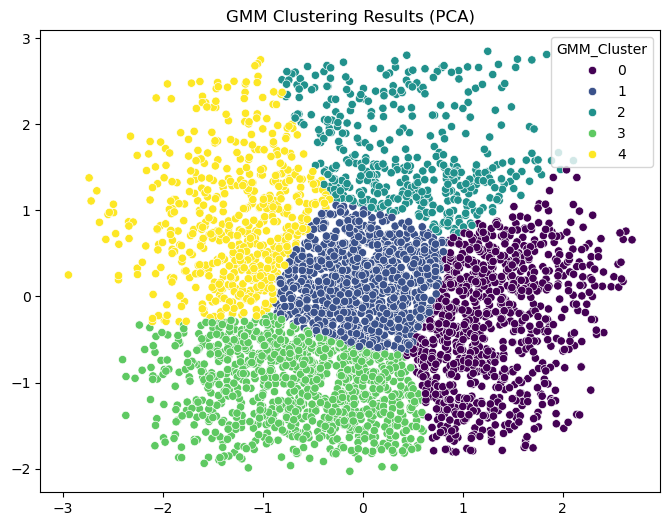


GMM Cluster Profiles:
               Recency  Frequency   Monetary  Engagement_Score
GMM_Cluster                                                   
0            25.500556   8.129032  81.880979          4.314127
1            30.163636  15.282828  57.055556          3.732727
2            39.261792  38.353774  67.943396          4.166038
3            12.737978   8.368008  50.680079          3.375859
4            28.973592  34.889085  39.672535          3.247535

GMM Persona Summary:
   GMM_Cluster    Recency  Frequency   Monetary  Engagement_Score  \
0            0  25.500556   8.129032  81.880979          4.314127   
1            1  30.163636  15.282828  57.055556          3.732727   
2            2  39.261792  38.353774  67.943396          4.166038   
3            3  12.737978   8.368008  50.680079          3.375859   
4            4  28.973592  34.889085  39.672535          3.247535   

                                             Persona  
0  Low Engagement Browser (Low across all me

In [11]:
# Copy for GMM analysis
df_gmm = df_base.copy()

# Feature selection and scaling for GMM
features_gmm = ['Recency', 'Frequency', 'Monetary', 'Engagement_Score']
scaler_gmm = StandardScaler()
df_gmm_scaled = scaler_gmm.fit_transform(df_gmm[features_gmm])

# PCA to reduce dimensionality before GMM
pca_gmm = PCA(n_components=2)
X_pca_gmm = pca_gmm.fit_transform(df_gmm_scaled)

# Optimal number of components for GMM using BIC
n_components_range = range(2, 10)
bic_scores = []
aic_scores = []
gmm_models = {}

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_pca_gmm)
    bic_scores.append(gmm.bic(X_pca_gmm))
    aic_scores.append(gmm.aic(X_pca_gmm))
    gmm_models[n_components] = gmm

# Optimal number of components, looking for the lowest BIC score
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f"\nOptimal Number of GMM Components (using BIC): {optimal_n_components}")

# Alternative numbers of components for comparison
alternative_components = [5]  # Testing 5 components based on results from other models
gmm_alternative_results = {}

for n_components in alternative_components:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_pca_gmm)
    labels = gmm.predict(X_pca_gmm)
    
    # Silhouette score
    silhouette = silhouette_score(X_pca_gmm, labels)
    gmm_alternative_results[n_components] = {"Silhouette Score": silhouette}

# Alternative results
for n_components, results in gmm_alternative_results.items():
    print(f"GMM with {n_components} Components - Silhouette Score: {results['Silhouette Score']:.4f}")

# GMM with 5 components (more interpretable)
gmm_final = GaussianMixture(n_components=5, random_state=42)
gmm_final.fit(X_pca_gmm)
df_gmm["GMM_Cluster"] = gmm_final.predict(X_pca_gmm)

# Silhouette score
silhouette_gmm = silhouette_score(X_pca_gmm, df_gmm["GMM_Cluster"])
print(f"GMM Final Silhouette Score: {silhouette_gmm:.4f}")

# GMM Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca_gmm[:, 0], y=X_pca_gmm[:, 1], hue=df_gmm["GMM_Cluster"], palette="viridis")
plt.title("GMM Clustering Results (PCA)")
plt.show()

# GMM personas based on cluster characteristics
gmm_profiles = df_gmm.groupby("GMM_Cluster")[features_gmm].mean()
print("\nGMM Cluster Profiles:")
print(gmm_profiles)

gmm_personas = {
    0: "Low Engagement Browser (Low across all metrics, particularly engagement score. These customers browse occasionally but rarely convert to significant purchases.)",
    1: "Moderate Value Loyal (Medium recency, frequency, and monetary values with good engagement. These are solid middle-tier customers.)",
    2: "High-Value Premium (High monetary value with good recency and frequency. These are premium customers who make regular valuable purchases.)",
    3: "Recent Low-Value Explorer (Low recency (recent purchases) but low monetary value. These may be new customers exploring the brand with small initial purchases.)",
    4: "Occasional Big Spender (High monetary value but low frequency. These customers shop infrequently but spend significantly when they do.)"
}

df_gmm["GMM_Persona"] = df_gmm["GMM_Cluster"].map(gmm_personas)

# Summary with persona descriptions
gmm_summary = df_gmm.groupby("GMM_Cluster")[features_gmm].mean().reset_index()
gmm_summary["Persona"] = gmm_summary["GMM_Cluster"].map(gmm_personas)
print("\nGMM Persona Summary:")
print(gmm_summary)


# Section 9: K-Prototypes for Mixed Data Types

We also include an early model we attempted on all the different features: KPrototypes. This model was on par with the RFME KMeans model, so it wasn't too good with an SS of 0.2310.


K-Prototypes Clustering Results:
   Customer ID  KPrototypes_Cluster
0            1                    1
1            2                    0
2            3                    3
3            4                    3
4            5                    1


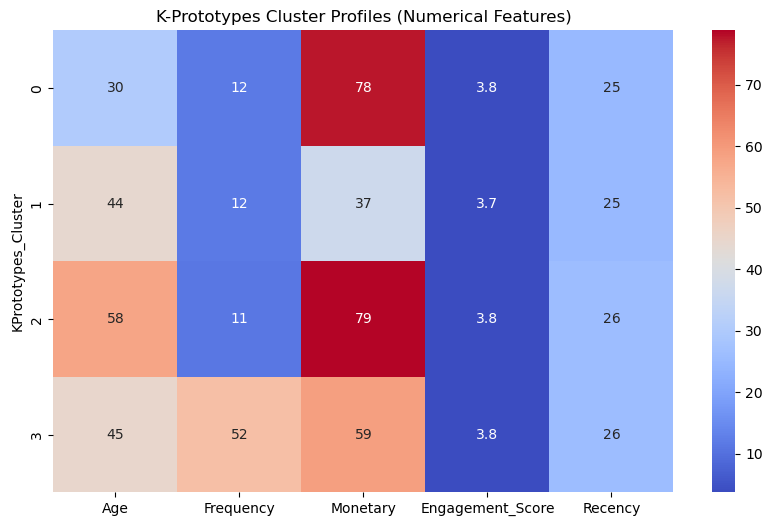


Most Common Categorical Values per Cluster:
                     Gender  Category  Size  Color  Season  \
KPrototypes_Cluster                                          
0                         1         1     1      8       3   
1                         1         1     1     19       1   
2                         1         1     1     22       0   
3                         1         1     1     24       3   

                     Subscription Status  Payment Method  
KPrototypes_Cluster                                       
0                                      0               5  
1                                      0               4  
2                                      0               2  
3                                      0               2  

K-Prototypes Cluster Summary:
   KPrototypes_Cluster        Age  Frequency   Monetary  Engagement_Score  \
0                    0  30.327064  11.933124  77.545455          3.765935   
1                    1  44.228246  11.66198

In [12]:
# Separate copy for K-Prototypes analysis
df_kproto = df_base.copy()

# Features for K-Prototypes
categorical_features = ['Gender', 'Category', 'Size', 'Color', 'Season', 'Subscription Status', 'Payment Method']
numerical_features = ['Age', 'Frequency', 'Monetary', 'Engagement_Score', 'Recency']

# Checking that the categorical features are strings
df_kproto[categorical_features] = df_kproto[categorical_features].astype(str)

# Encoding categorical features
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    df_kproto[col] = le.fit_transform(df_kproto[col])
    label_encoders[col] = le

# Preparing data for K-Prototypes
X_kproto = df_kproto[numerical_features + categorical_features].values
categorical_indices = [len(numerical_features) + i for i in range(len(categorical_features))]

# K-Prototypes clustering
kproto = KPrototypes(n_clusters=4, init='Huang', random_state=42)
clusters = kproto.fit_predict(X_kproto, categorical=categorical_indices)
df_kproto['KPrototypes_Cluster'] = clusters

# KPrototypes clusters
print("\nK-Prototypes Clustering Results:")
print(df_kproto[["Customer ID", "KPrototypes_Cluster"]].head())

# Compute mean values for numerical features per cluster
cluster_means_kproto = df_kproto.groupby("KPrototypes_Cluster")[numerical_features].mean()

# Cluster profiles
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_kproto, annot=True, cmap="coolwarm")
plt.title("K-Prototypes Cluster Profiles (Numerical Features)")
plt.show()

# Getting mode (most frequent category) for categorical features in each cluster
cluster_modes_kproto = df_kproto.groupby("KPrototypes_Cluster")[categorical_features].agg(lambda x: x.mode()[0])
print("\nMost Common Categorical Values per Cluster:")
print(cluster_modes_kproto)

# K-Prototypes personas
kproto_personas = {
    0: "Luxury High-Spender (High frequency and moderate monetary spend, suggesting they are engaged, frequent shoppers who make regular purchases.)",
    1: "Infrequent High-Spender (Older age with moderate spending but low frequency, indicating they buy less often but in higher amounts.)",
    2: "Loyal Subscription Shopper (Moderate frequency, moderate spend, and steady engagement suggest customers who consistently purchase—likely through subscriptions or repeat orders.)",
    3: "Moderate-Frequency Engaged Shopper (Lower recency and decent engagement, meaning they may shop semi-regularly but without strong spending patterns.)"
    }

# Map personas to clusters
df_kproto["KPrototypes_Persona"] = df_kproto["KPrototypes_Cluster"].map(kproto_personas)

# Display persona summary
cluster_summary_kproto = df_kproto.groupby("KPrototypes_Cluster")[numerical_features].mean().reset_index()
cluster_summary_kproto["Persona"] = cluster_summary_kproto["KPrototypes_Cluster"].map(kproto_personas)
print("\nK-Prototypes Cluster Summary:")
print(cluster_summary_kproto)

# Silhouette Score for K-Prototypes
silhouette_kproto1 = silhouette_score(X_kproto, clusters)
print(f"\nSilhouette Score for K-Prototypes: {silhouette_kproto1:.4f}")

In [13]:
# Silhouette score for K-Prototypes
df_kproto_num = df_kproto.copy()
df_kproto_num[categorical_features] = df_kproto_num[categorical_features].astype('category').apply(lambda x: x.cat.codes)
X_kproto_num = df_kproto_num[numerical_features + categorical_features].values
silhouette_kproto = silhouette_score(X_kproto_num, df_kproto["KPrototypes_Cluster"])
print(f"\nK-Prototypes Silhouette Score: {silhouette_kproto:.4f}")


K-Prototypes Silhouette Score: 0.2310


# Section 10: UMAP

We finally try using UMAP for both clustering help and visualization. We also try adding embeddings using some quantile calculations  t see if we can better divide the samples we have into more distinct groups.

In [14]:
# Separate copy for Umap analysis
df_umap = df_base.copy()

df_umap['customer_profile'] = df_umap.apply(
    lambda row: f"A {row['Gender']} customer, age {row['Age']}, purchased {row['Item Purchased']} " +
    f"from {row['Category']} category, {row['Color']} color, in {row['Season']}, size {row['Size']}. " +
    f"Previous purchases: {row['Previous Purchases']}. " +
    f"Purchase frequency: {row['Frequency of Purchases']}. " +
    f"They spent ${row['Purchase Amount (USD)']}. " +
    f"Rating: {row['Review Rating']}/5. " +
    f"Discount applied: {row['Discount Applied']}. " +
    f"Promo code used: {row['Promo Code Used']}. " +
    f"Subscription status: {row['Subscription Status']}. " +
    f"Shipping type: {row['Shipping Type']}. " +
    f"Payment method: {row['Payment Method']}.",
    axis=1
)

# Compute quantile thresholds for Purchase Amount and Previous Purchases
low_purchase = df_umap['Purchase Amount (USD)'].quantile(0.25)
high_purchase = df_umap['Purchase Amount (USD)'].quantile(0.75)
low_prev = df_umap['Previous Purchases'].quantile(0.25)
high_prev = df_umap['Previous Purchases'].quantile(0.75)

def spending_level(amount):
    if amount > high_purchase:
        return "high spender"
    elif amount < low_purchase:
        return "budget-conscious spender"
    else:
        return "moderate spender"

def loyalty_level(prev):
    if prev > high_prev:
        return "loyal"
    elif prev < low_prev:
        return "new"
    else:
        return "returning"

# More diverse customer profile string
df_umap['customer_profile'] = df_umap.apply(
    lambda row: (
        f"Profile:\n"
        f"- Customer: A {row['Gender']} aged {row['Age']} years.\n"
        f"- Spending Behavior: A {spending_level(row['Purchase Amount (USD)'])} who spent ${row['Purchase Amount (USD)']:.2f} and made {row['Previous Purchases']} past purchases, thus classified as a {loyalty_level(row['Previous Purchases'])} customer.\n"
        f"- Purchase Details: Purchased a {row['Item Purchased']} from the {row['Category']} category, noted for its {row['Color']} color, size {row['Size']}, during {row['Season']} season.\n"
        f"- Experience: Rated {row['Review Rating']}/5; shops {row['Frequency of Purchases']}, discount applied: {row['Discount Applied']}, promo code used: {row['Promo Code Used']}.\n"
        f"- Engagement: Subscription status: {row['Subscription Status']}, prefers {row['Shipping Type']} shipping, and uses {row['Payment Method']} for payment."
    ),
    axis=1
)

# Create new embeddings using the diversified customer profiles
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df_umap['customer_profile'].tolist(), show_progress_bar=True)

# Display a few sample profiles to verify the changes
print(df_umap[['customer_profile']].head())

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

                                    customer_profile
0  Profile:\n- Customer: A Male aged 55 years.\n-...
1  Profile:\n- Customer: A Male aged 19 years.\n-...
2  Profile:\n- Customer: A Male aged 50 years.\n-...
3  Profile:\n- Customer: A Male aged 21 years.\n-...
4  Profile:\n- Customer: A Male aged 45 years.\n-...


In [15]:
numeric_cols = ['Age', 'Purchase Amount (USD)', 'Review Rating', 'Previous Purchases', 'Frequency of Purchases (Numeric)']
scaler = StandardScaler()
numeric_scaled = scaler.fit_transform(df_umap[numeric_cols])
embeddings_numeric = np.concatenate([embeddings, numeric_scaled], axis=1)

# Sample profiles to verify the changes
print(df_umap[['customer_profile']].head())

                                    customer_profile
0  Profile:\n- Customer: A Male aged 55 years.\n-...
1  Profile:\n- Customer: A Male aged 19 years.\n-...
2  Profile:\n- Customer: A Male aged 50 years.\n-...
3  Profile:\n- Customer: A Male aged 21 years.\n-...
4  Profile:\n- Customer: A Male aged 45 years.\n-...


In [16]:
import umap.umap_ as umap

# Use UMAP to reduce dimensionality for visualization and clustering
print("Reducing dimensionality...")
reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
umap_embeddings = reducer.fit_transform(embeddings_numeric)

combined_features = np.hstack((embeddings, numeric_scaled))

Reducing dimensionality...


/Users/huanlindai/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Finding optimal number of clusters...


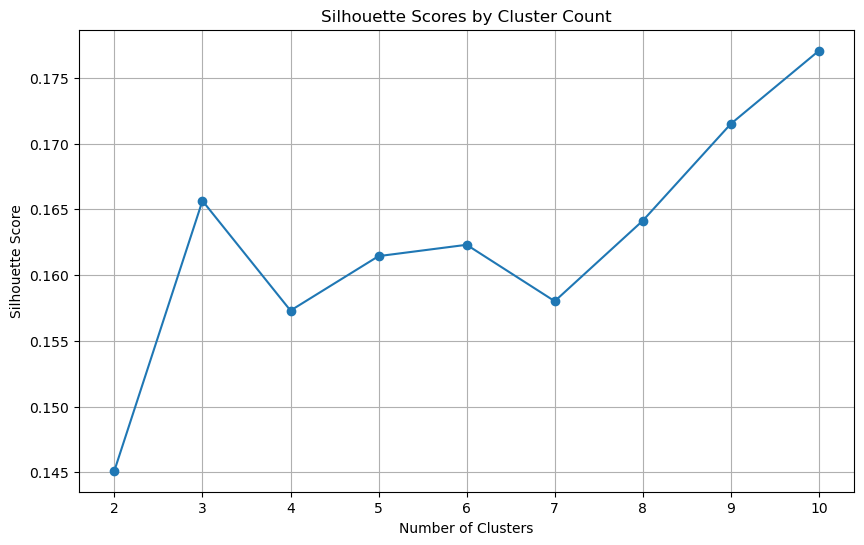

In [17]:
# Optimal number of clusters
print("Finding optimal number of clusters...")
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(combined_features)
    silhouette_scores.append(silhouette_score(combined_features, cluster_labels))

# Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores by Cluster Count')
plt.grid(True)
plt.savefig('llm_silhouette_scores.png')

In [18]:
# Best K based on silhouette score
best_k = np.argmax(silhouette_scores) + 2
print(f"Optimal number of clusters: {best_k} (Silhouette Score: {silhouette_scores[best_k-2]:.4f})")

# K-means with optimal K
print(f"Clustering with K={best_k}...")
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(combined_features)


Optimal number of clusters: 10 (Silhouette Score: 0.1771)
Clustering with K=10...


It doesn't look like any UMAP-based KMeans clustering is outperforming GMM.

In [19]:
# 2D UMAP projection for visualization
viz_reducer = umap.UMAP(n_components=2, metric='cosine', random_state=42)
viz_embedding = viz_reducer.fit_transform(embeddings_numeric)
df['UMAP1'] = viz_embedding[:, 0]
df['UMAP2'] = viz_embedding[:, 1]

# Profile the clusters
segment_stats = df.groupby('Cluster').agg({
    'Customer ID': 'count',
    'Purchase Amount (USD)': 'mean',
    'Age': 'mean',
    'Previous Purchases': 'mean',
    'Review Rating': 'mean'
}).round(2)

segment_stats['Percentage'] = (segment_stats['Customer ID'] / len(df) * 100).round(1)
segment_stats = segment_stats.rename(columns={'Customer ID': 'Count'})

print("\nSegment Statistics:")
print(segment_stats)

/Users/huanlindai/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Segment Statistics:
         Count  Purchase Amount (USD)    Age  Previous Purchases  \
Cluster                                                            
0          405                  39.65  55.91               35.93   
1          429                  78.36  32.95               13.55   
2          434                  41.45  56.64               15.98   
3          272                  58.74  41.52               14.04   
4          457                  40.60  30.77               14.32   
5          432                  44.10  33.79               37.31   
6          266                  59.07  47.77               37.85   
7          383                  81.11  57.52               38.05   
8          396                  78.86  31.09               36.35   
9          426                  79.40  55.19               14.20   

         Review Rating  Percentage  
Cluster                             
0                 4.29        10.4  
1                 3.16        11.0  
2             

In [20]:
# Automatically generate segment names using profile features
segment_names = {}
for cluster in range(best_k):
    cluster_df = df[df['Cluster'] == cluster]
    
    # Calculate key metrics
    avg_spending = cluster_df['Purchase Amount (USD)'].mean()
    avg_previous = cluster_df['Previous Purchases'].mean()
    avg_rating = cluster_df['Review Rating'].mean()
    discount_rate = (cluster_df['Discount Applied'] == 'Yes').mean()
    subscription_rate = (cluster_df['Subscription Status'] == 'Yes').mean()
    
    # Top categories, colors, and seasons
    top_category = cluster_df['Category'].value_counts().index[0]
    top_season = cluster_df['Season'].value_counts().index[0]
    top_items = cluster_df['Item Purchased'].value_counts().nlargest(2).index.tolist()
    
    # Determine spending level
    if avg_spending > df['Purchase Amount (USD)'].quantile(0.75):
        spending = "High-Spending"
    elif avg_spending < df['Purchase Amount (USD)'].quantile(0.25):
        spending = "Budget-Conscious"
    else:
        spending = "Mid-Range"
    
    # Determine loyalty level
    if avg_previous > df['Previous Purchases'].quantile(0.75):
        loyalty = "Loyal"
    elif avg_previous < df['Previous Purchases'].quantile(0.25):
        loyalty = "New"
    else:
        loyalty = "Returning"
    
    # Create segment name
    if subscription_rate > 0.5:
        prefix = "Subscribed"
    elif discount_rate > 0.7:
        prefix = "Discount-Seeking"
    else:
        prefix = ""
    
    if prefix:
        name = f"{prefix} {loyalty} {spending} Shoppers"
    else:
        name = f"{loyalty} {spending} Shoppers"
    
    # Add specialty if very focused on one category
    if cluster_df['Category'].value_counts(normalize=True).iloc[0] > 0.6:
        name += f" ({top_category} Focus)"
    
    segment_names[cluster] = name


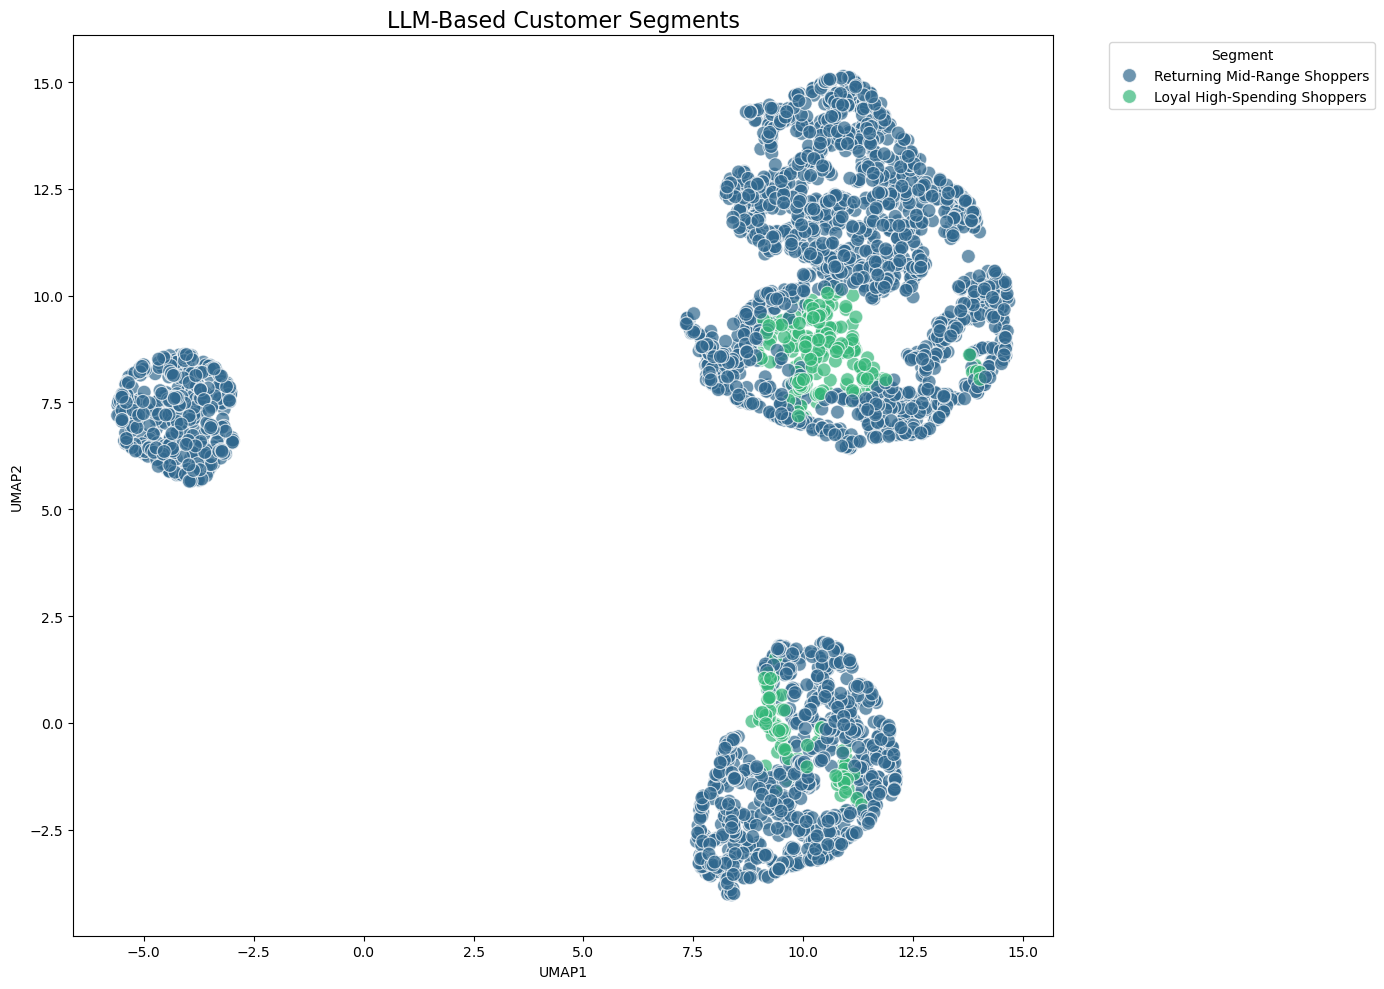

In [21]:
# Map cluster numbers to names
df['Segment'] = df['Cluster'].map(segment_names)

# Visualize the clusters
plt.figure(figsize=(14, 10))
scatter = sns.scatterplot(
    data=df,
    x='UMAP1',
    y='UMAP2',
    hue='Segment',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('LLM-Based Customer Segments', fontsize=16)
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Here are some segment profiles and marketing recommendations drawn from the segments we just created.

In [22]:
# Generate segment insights and marketing recommendations
print("\n--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---")

for cluster, segment_name in segment_names.items():
    segment_data = df[df['Cluster'] == cluster]
    count = len(segment_data)
    pct = count / len(df) * 100
    
    print(f"\n=== {segment_name} ===")
    print(f"Size: {count} customers ({pct:.1f}% of total)")
    
    # Calculate key metrics
    avg_purchase = segment_data['Purchase Amount (USD)'].mean()
    freq_counts = segment_data['Frequency of Purchases'].value_counts().nlargest(2)
    avg_previous = segment_data['Previous Purchases'].mean()
    avg_rating = segment_data['Review Rating'].mean()
    discount_usage = (segment_data['Discount Applied'] == 'Yes').mean() * 100
    promo_usage = (segment_data['Promo Code Used'] == 'Yes').mean() * 100
    subscription_rate = (segment_data['Subscription Status'] == 'Yes').mean() * 100
    
    # Top categories and products
    top_categories = segment_data['Category'].value_counts().nlargest(2)
    top_items = segment_data['Item Purchased'].value_counts().nlargest(3)
    top_seasons = segment_data['Season'].value_counts().nlargest(2)
    top_colors = segment_data['Color'].value_counts().nlargest(3)
    
    # Print segment profile
    print("\nKEY CHARACTERISTICS:")
    print(f"• Average purchase: ${avg_purchase:.2f}")
    print(f"• Purchase frequency: {', '.join([f'{freq} ({count})' for freq, count in freq_counts.items()])}")
    print(f"• Previous purchases: {avg_previous:.1f}")
    print(f"• Average rating: {avg_rating:.1f}/5")
    print(f"• Discount usage: {discount_usage:.1f}%")
    print(f"• Promo code usage: {promo_usage:.1f}%")
    print(f"• Subscription rate: {subscription_rate:.1f}%")
    
    print("\nPRODUCT PREFERENCES:")
    print("• Top categories:")
    for cat, count in top_categories.items():
        print(f"  - {cat}: {count} purchases ({count/len(segment_data)*100:.1f}% of segment)")
    
    print("• Top items:")
    for item, count in top_items.items():
        print(f"  - {item}: {count} purchases")
    
    print("• Top seasons:")
    for season, count in top_seasons.items():
        print(f"  - {season}: {count} purchases")
    
    print("• Top colors:")
    for color, count in top_colors.items():
        print(f"  - {color}: {count} purchases")
    


--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---

=== Returning Mid-Range Shoppers ===
Size: 405 customers (10.4% of total)

KEY CHARACTERISTICS:
• Average purchase: $39.65
• Purchase frequency: Fortnightly (75), Every 3 Months (72)
• Previous purchases: 35.9
• Average rating: 4.3/5
• Discount usage: 43.2%
• Promo code usage: 43.2%
• Subscription rate: 0.0%

PRODUCT PREFERENCES:
• Top categories:
  - Clothing: 169 purchases (41.7% of segment)
  - Accessories: 137 purchases (33.8% of segment)
• Top items:
  - Jewelry: 31 purchases
  - Blouse: 26 purchases
  - Gloves: 24 purchases
• Top seasons:
  - Spring: 106 purchases
  - Summer: 102 purchases
• Top colors:
  - Silver: 23 purchases
  - Turquoise: 23 purchases
  - Teal: 23 purchases

=== Returning Mid-Range Shoppers ===
Size: 429 customers (11.0% of total)

KEY CHARACTERISTICS:
• Average purchase: $78.36
• Purchase frequency: Bi-Weekly (83), Every 3 Months (76)
• Previous purchases: 13.5
• Average rating: 3.2/5
• Discount usage: 4

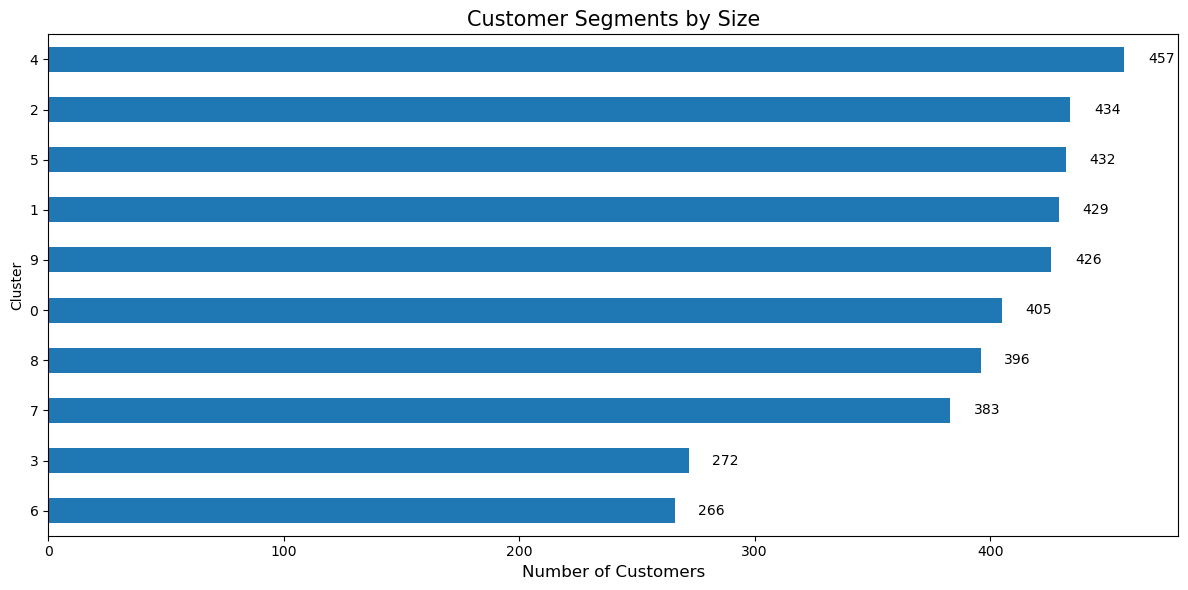

In [23]:
# Visualize segments bar chart showing segment sizes
plt.figure(figsize=(12, 6))
ax = segment_stats['Count'].sort_values().plot(kind='barh')
plt.title('Customer Segments by Size', fontsize=15)
plt.xlabel('Number of Customers', fontsize=12)
for i, v in enumerate(segment_stats['Count'].sort_values()):
    ax.text(v + 10, i, str(v), va='center')
plt.tight_layout()
plt.show()

In [24]:
# Table with the key characteristics per cluster
print("\nSegment Statistics:")
print(segment_stats)


Segment Statistics:
         Count  Purchase Amount (USD)    Age  Previous Purchases  \
Cluster                                                            
0          405                  39.65  55.91               35.93   
1          429                  78.36  32.95               13.55   
2          434                  41.45  56.64               15.98   
3          272                  58.74  41.52               14.04   
4          457                  40.60  30.77               14.32   
5          432                  44.10  33.79               37.31   
6          266                  59.07  47.77               37.85   
7          383                  81.11  57.52               38.05   
8          396                  78.86  31.09               36.35   
9          426                  79.40  55.19               14.20   

         Review Rating  Percentage  
Cluster                             
0                 4.29        10.4  
1                 3.16        11.0  
2             

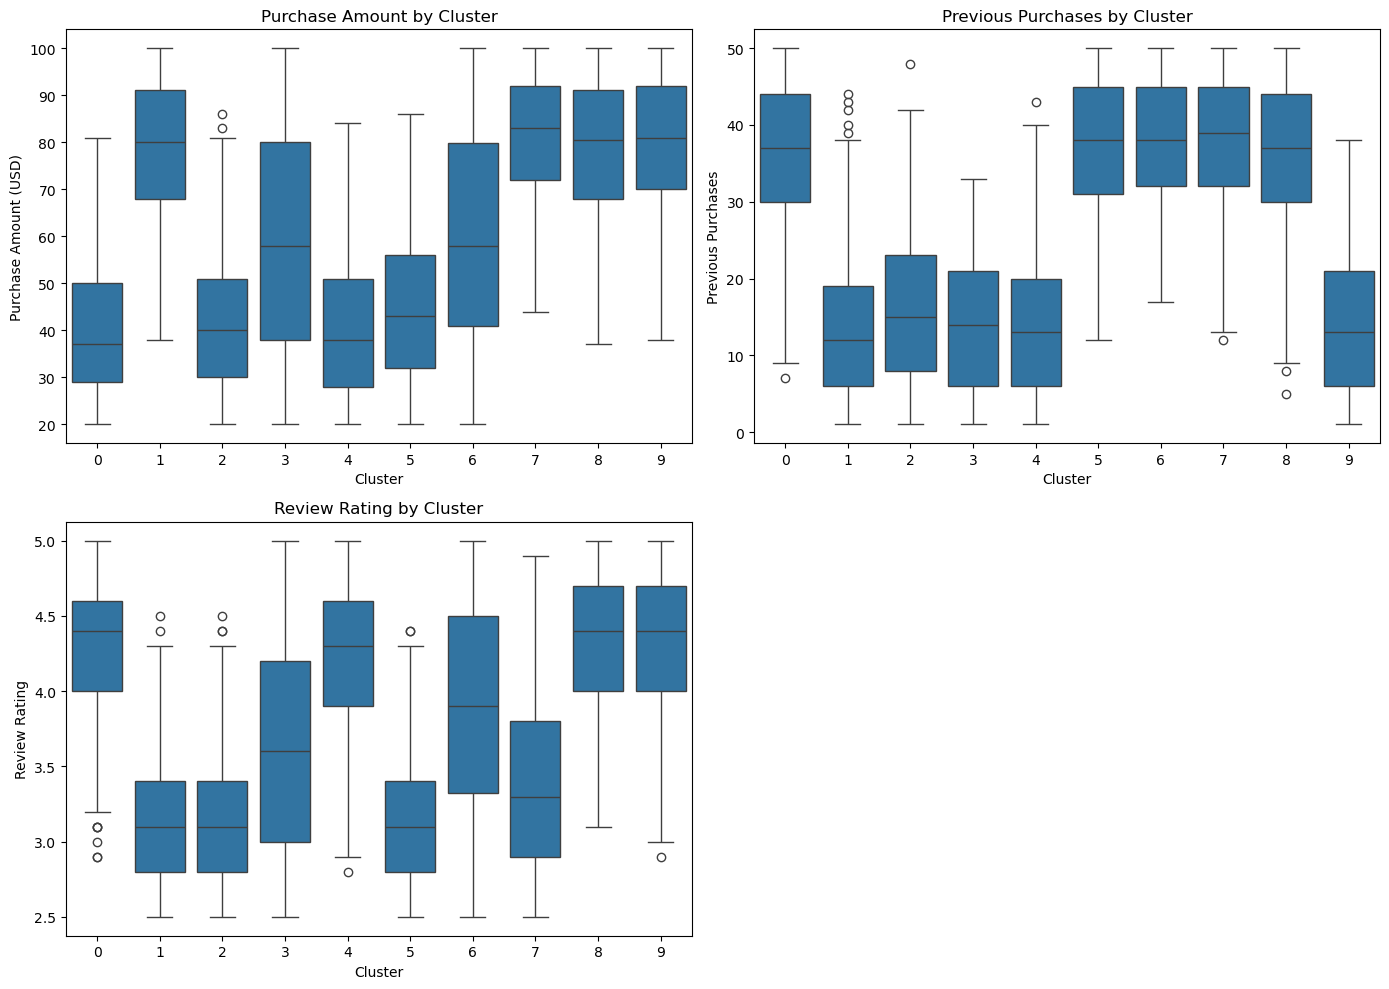

In [25]:
# Creating a of key metrics by cluster
plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='Cluster', y='Purchase Amount (USD)')
plt.title('Purchase Amount by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Purchase Amount (USD)')
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Cluster', y='Previous Purchases')
plt.title('Previous Purchases by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Previous Purchases')
plt.subplot(2, 2, 3)
sns.boxplot(data=df, x='Cluster', y='Review Rating')

plt.title('Review Rating by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Review Rating')
plt.tight_layout()
plt.show()

# Section 11: Model Comparision

In [26]:
# Models comparison
print("\n--- CLUSTERING MODEL COMPARISON ---")
print("Silhouette Scores:")
print(f"K-Means: 0.3147")
print(f"Hierarchical: {silhouette_hierarchical:.4f}")
print(f"DBSCAN: {silhouette_dbscan:.4f}")
print(f"RFME: {silhouette_rfme:.4f}")
print(f"GMM: {silhouette_gmm:.4f}")
print(f"K-Prototypes: {silhouette_kproto:.4f}")
print(f"Umap: {silhouette_scores[best_k-2]:.4f}")


--- CLUSTERING MODEL COMPARISON ---
Silhouette Scores:
K-Means: 0.3147
Hierarchical: 0.2619
DBSCAN: 0.1924
RFME: 0.2246
GMM: 0.3268
K-Prototypes: 0.2310
Umap: 0.1771


/var/folders/tg/s24dm7414nqfb930bbwqp7wh0000gn/T/ipykernel_22401/2616664016.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=silhouette_scores, palette="viridis")


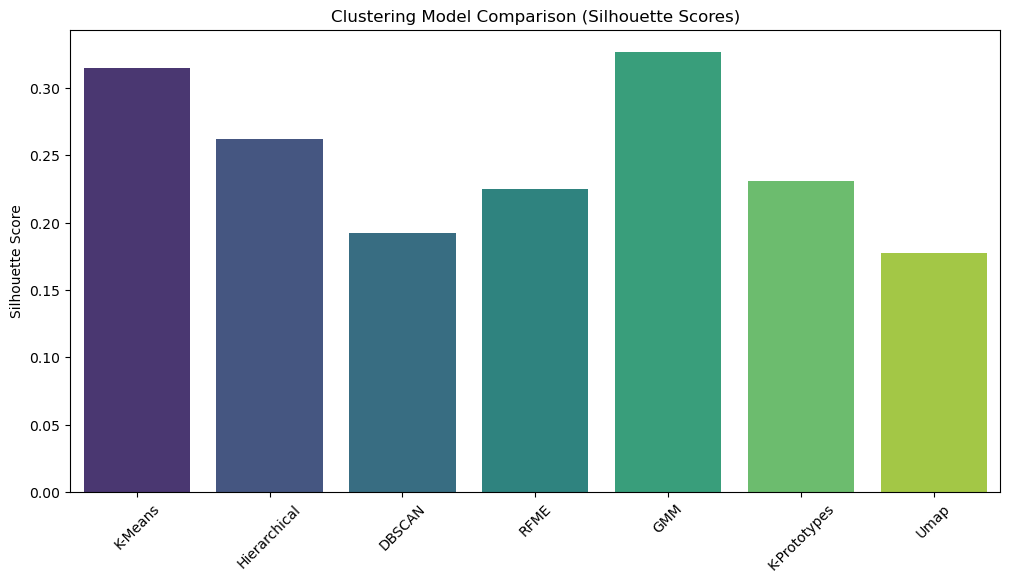

In [27]:
# Models comparison clustering metrics
plt.figure(figsize=(12, 6))
models = ["K-Means", "Hierarchical", "DBSCAN", "RFME", "GMM", "K-Prototypes", "Umap"]
silhouette_scores = [0.3147, silhouette_hierarchical, silhouette_dbscan, silhouette_rfme, silhouette_gmm, silhouette_kproto, silhouette_scores[best_k-2] if best_k-2 < len(silhouette_scores) else silhouette_scores[-1]]
sns.barplot(x=models, y=silhouette_scores, palette="viridis")
plt.title("Clustering Model Comparison (Silhouette Scores)")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45)
plt.show()


In [28]:
# Cluster personas
print("\n--- CLUSTER PERSONAS ---")
print("K-Means:")
print(cluster_profiles_kmeans)
print("\nHierarchical:")
print(cluster_profiles_hierarchical)
print("\nDBSCAN:")
print(dbscan_profiles)
print("\nRFME:")
print(cluster_summary_rfme)
print("\nGMM:")
print(gmm_summary)
print("\nK-Prototypes:")
print(cluster_summary_kproto)
print("\nUmap:")
print(segment_stats)


--- CLUSTER PERSONAS ---
K-Means:
   KMeans_Cluster    Recency  Frequency   Monetary  Loyalty_Score  \
0               0  25.771800  52.000000  58.972171      80.684601   
1               1  13.091873  11.617197  38.994111      27.170789   
2               2  37.673243  11.458693  38.987670      52.066584   
3               3  38.209467  11.750296  80.422485      52.598817   
4               4  12.879673  11.601636  80.155374      27.121495   

   Engagement_Score                                            Persona  
0          3.759555  High-Value Loyal Customer (High monetary spend...  
1          3.713310  Recent Engaged Shopper (Good engagement score ...  
2          3.711837  Frequent Low-Spender (High frequency but low m...  
3          3.782485  Infrequent Low-Spender (Low frequency and low ...  
4          3.784229  Dormant High-Value Customer (High recency, mea...  

Hierarchical:
   Hierarchical_Cluster    Recency  Frequency   Monetary  \
0                     0  22.444444  1

/var/folders/tg/s24dm7414nqfb930bbwqp7wh0000gn/T/ipykernel_22401/1550642355.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=cluster_counts, palette="viridis")


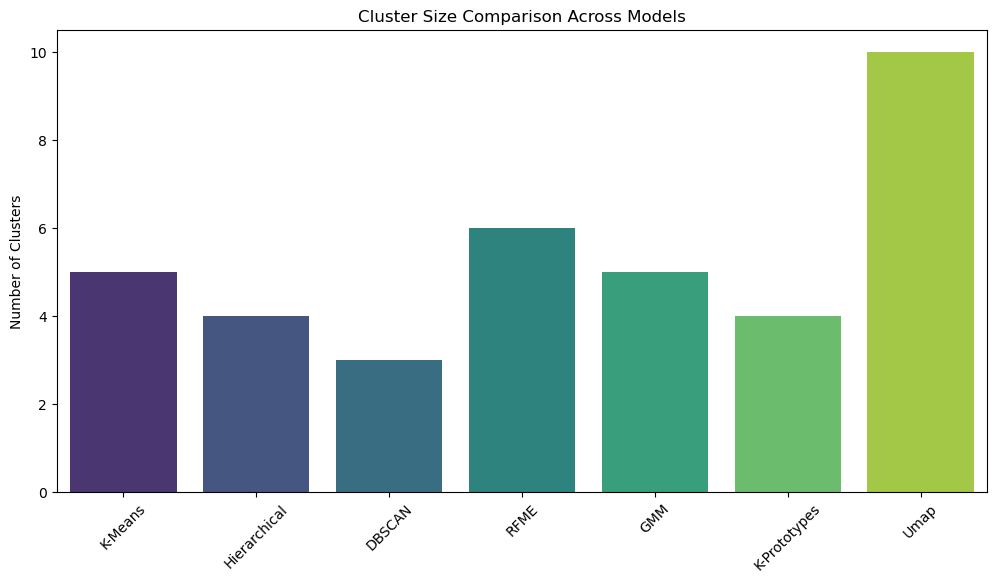

In [29]:
#Cluster size comparison across models
plt.figure(figsize=(12, 6))
models = ["K-Means", "Hierarchical", "DBSCAN", "RFME", "GMM", "K-Prototypes", "Umap"]
cluster_counts = [len(cluster_profiles_kmeans), len(cluster_profiles_hierarchical), len(dbscan_profiles), len(cluster_summary_rfme), len(gmm_summary), len(cluster_summary_kproto), len(segment_stats)]
sns.barplot(x=models, y=cluster_counts, palette="viridis")
plt.title("Cluster Size Comparison Across Models")
plt.ylabel("Number of Clusters")
plt.xticks(rotation=45)
plt.show()

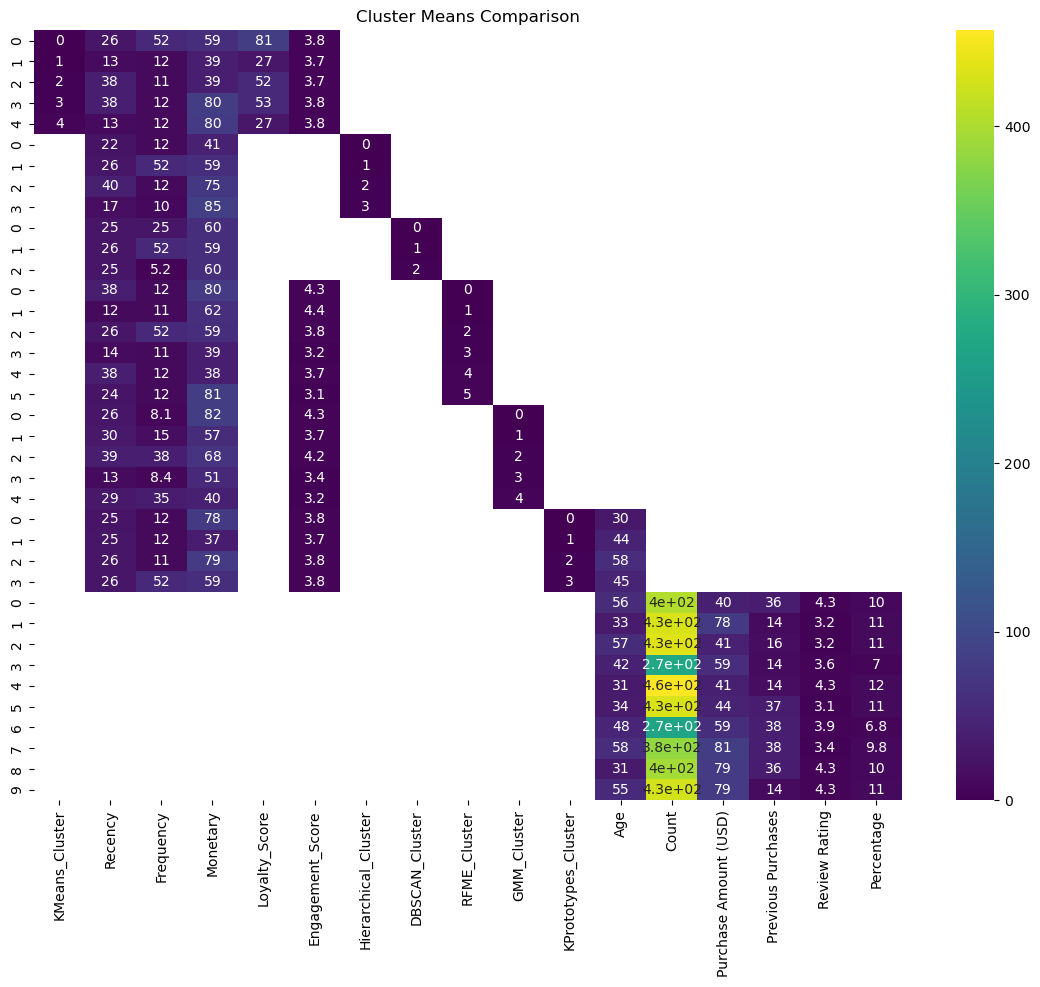

In [30]:
# Compute mean values for each method's cluster, excluding non-numeric columns
cluster_means_combined = pd.concat([
    cluster_profiles_kmeans.select_dtypes(include=[np.number]),
    cluster_profiles_hierarchical.select_dtypes(include=[np.number]),
    dbscan_profiles.select_dtypes(include=[np.number]),
    cluster_summary_rfme.select_dtypes(include=[np.number]),
    gmm_summary.select_dtypes(include=[np.number]),
    cluster_summary_kproto.select_dtypes(include=[np.number]),
    segment_stats.select_dtypes(include=[np.number])
])  

# Heatmap of cluster means
plt.figure(figsize=(14, 10))
sns.heatmap(cluster_means_combined, annot=True, cmap="viridis")
plt.title("Cluster Means Comparison")
plt.show()


# Section 12: Best Model GMM

In [31]:
gmm_profiles = df_gmm.groupby("GMM_Cluster")[features_gmm].mean().reset_index()
print("\nGMM Cluster Profiles:")
print(gmm_profiles)


GMM Cluster Profiles:
   GMM_Cluster    Recency  Frequency   Monetary  Engagement_Score
0            0  25.500556   8.129032  81.880979          4.314127
1            1  30.163636  15.282828  57.055556          3.732727
2            2  39.261792  38.353774  67.943396          4.166038
3            3  12.737978   8.368008  50.680079          3.375859
4            4  28.973592  34.889085  39.672535          3.247535


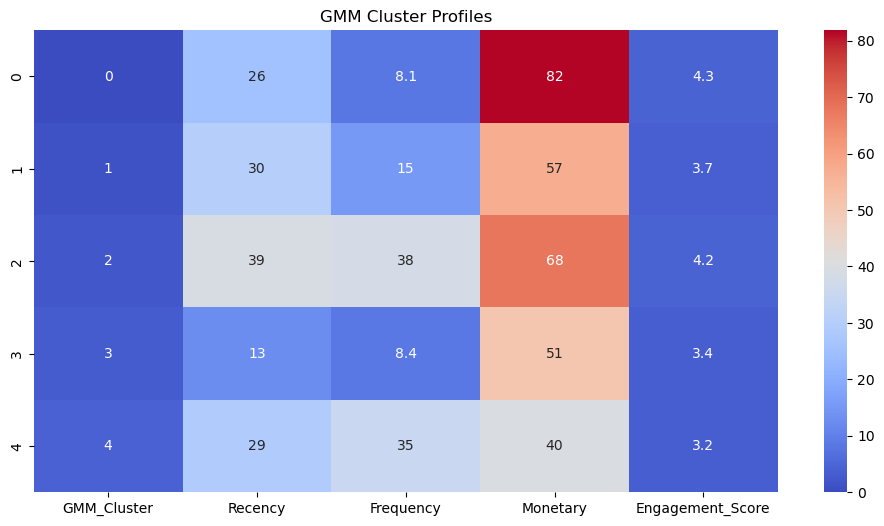

In [32]:
#Heatmap GMM cluster profiles
plt.figure(figsize=(12, 6))
sns.heatmap(gmm_profiles, annot=True, cmap="coolwarm")
plt.title("GMM Cluster Profiles")
plt.show()

<Figure size 1200x600 with 0 Axes>

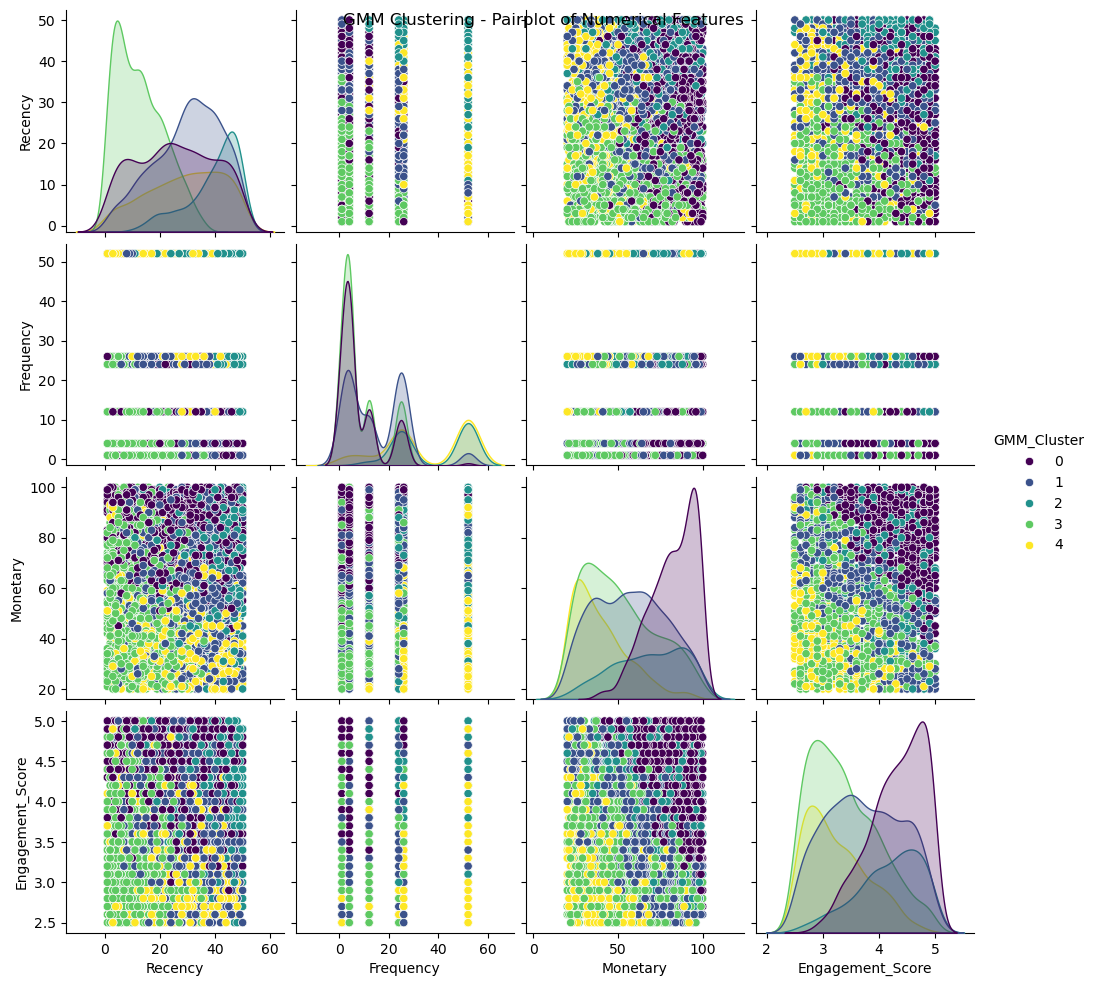

/var/folders/tg/s24dm7414nqfb930bbwqp7wh0000gn/T/ipykernel_22401/2081717367.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="GMM_Cluster", y="Monetary", data=df_gmm, palette="viridis")


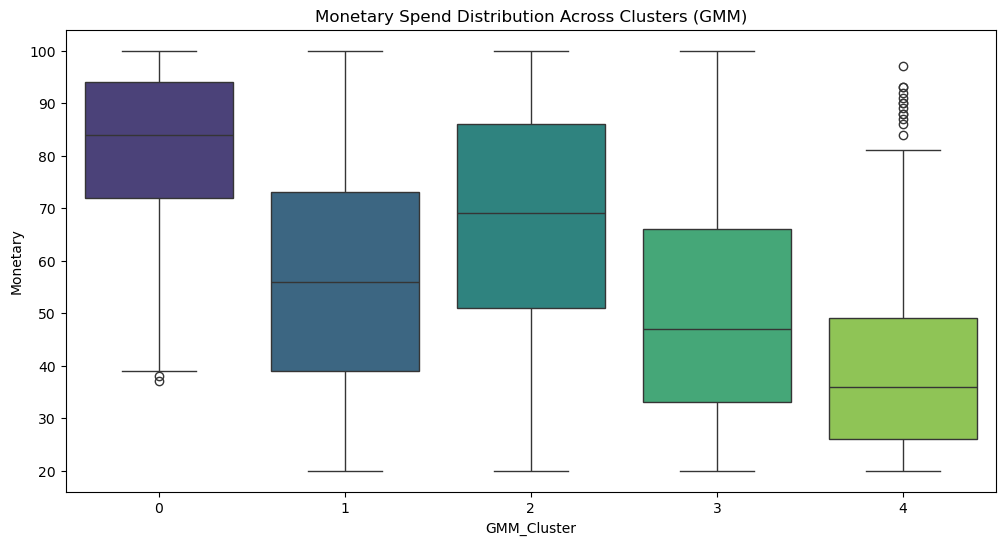

/var/folders/tg/s24dm7414nqfb930bbwqp7wh0000gn/T/ipykernel_22401/2081717367.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="GMM_Cluster", y="Age", data=df_gmm, palette="viridis")


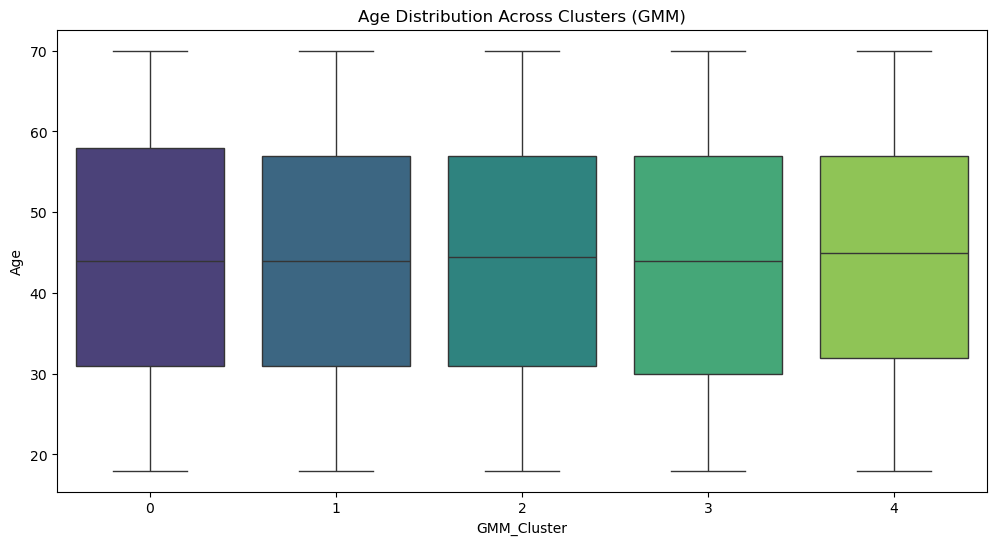

/var/folders/tg/s24dm7414nqfb930bbwqp7wh0000gn/T/ipykernel_22401/2081717367.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="GMM_Cluster", y="Engagement_Score", data=df_gmm, palette="viridis")


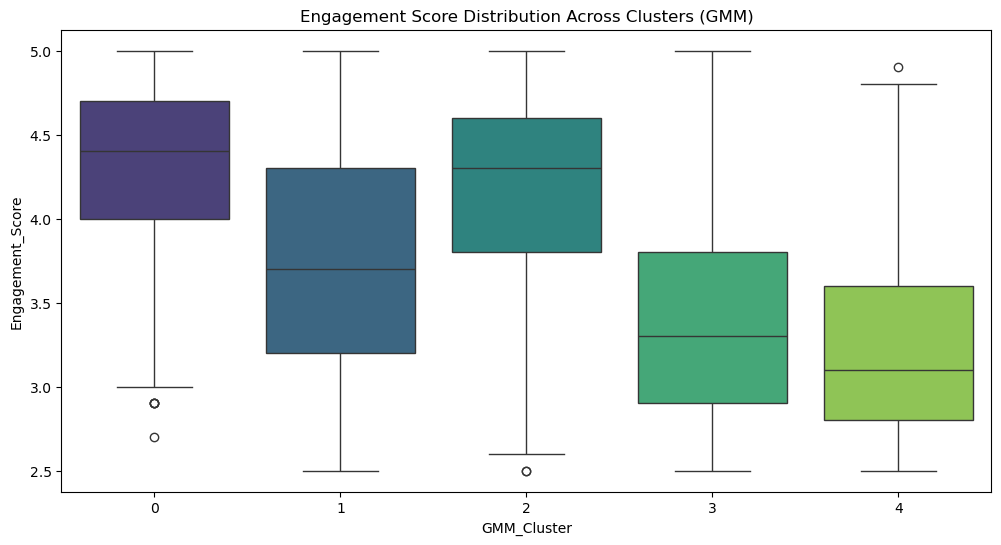

/var/folders/tg/s24dm7414nqfb930bbwqp7wh0000gn/T/ipykernel_22401/2081717367.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="GMM_Cluster", y="Recency", data=df_gmm, palette="viridis")


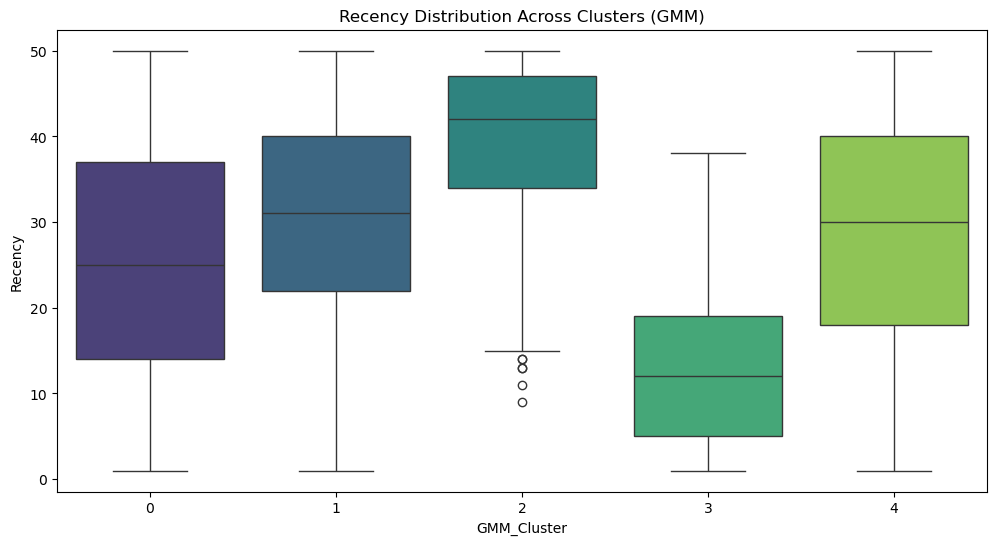

/var/folders/tg/s24dm7414nqfb930bbwqp7wh0000gn/T/ipykernel_22401/2081717367.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="GMM_Cluster", y="Frequency", data=df_gmm, palette="viridis")


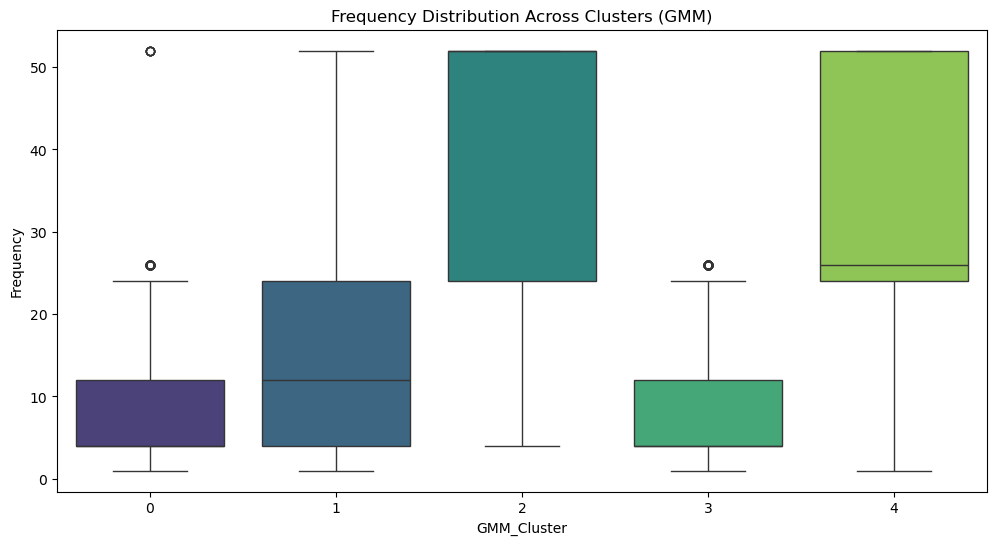

In [33]:
# Plot of numerical features to check in GMM
features_gmm = ['Recency', 'Frequency', 'Monetary', 'Engagement_Score']

plt.figure(figsize=(12, 6))
sns.pairplot(df_gmm, hue="GMM_Cluster", vars=features_gmm, palette="viridis")
plt.suptitle("GMM Clustering - Pairplot of Numerical Features")
plt.show()

# Boxplot of spending by cluster in GMM
plt.figure(figsize=(12, 6))
sns.boxplot(x="GMM_Cluster", y="Monetary", data=df_gmm, palette="viridis")
plt.title("Monetary Spend Distribution Across Clusters (GMM)")
plt.show()

# Boxplot of age by cluster in GMM
plt.figure(figsize=(12, 6))
sns.boxplot(x="GMM_Cluster", y="Age", data=df_gmm, palette="viridis")
plt.title("Age Distribution Across Clusters (GMM)")
plt.show()

# Boxplot of engagement score by cluster in GMM
plt.figure(figsize=(12, 6))
sns.boxplot(x="GMM_Cluster", y="Engagement_Score", data=df_gmm, palette="viridis")
plt.title("Engagement Score Distribution Across Clusters (GMM)")
plt.show()

# Boxplot of recency by cluster in GMM
plt.figure(figsize=(12, 6))
sns.boxplot(x="GMM_Cluster", y="Recency", data=df_gmm, palette="viridis")
plt.title("Recency Distribution Across Clusters (GMM)")
plt.show()

# Boxplot of frequency by cluster in GMM
plt.figure(figsize=(12, 6))
sns.boxplot(x="GMM_Cluster", y="Frequency", data=df_gmm, palette="viridis")
plt.title("Frequency Distribution Across Clusters (GMM)")
plt.show()


In [34]:
# GMM personas
gmm_personas = {
    0: "Low Engagement Browser (Low across all metrics, particularly engagement score. These customers browse occasionally but rarely convert to significant purchases.)",
    1: "Moderate Value Loyal (Medium recency, frequency, and monetary values with good engagement. These are solid middle-tier customers.)",
    2: "High-Value Premium (High monetary value with good recency and frequency. These are premium customers who make regular valuable purchases.)",
    3: "Recent Low-Value Explorer (Low recency (recent purchases) but low monetary value. These may be new customers exploring the brand with small initial purchases.)",
    4: "Occasional Big Spender (High monetary value but low frequency. These customers shop infrequently but spend significantly when they do.)"
}

df_gmm["GMM_Persona"] = df_gmm["GMM_Cluster"].map(gmm_personas)

# Cluster profiles with persona descriptions
gmm_profiles = df_gmm.groupby("GMM_Cluster")[features_gmm].mean().reset_index()
gmm_profiles["Persona"] = gmm_profiles["GMM_Cluster"].map(gmm_personas)

print("\nGMM Customer Personas:")
print(gmm_profiles)



GMM Customer Personas:
   GMM_Cluster    Recency  Frequency   Monetary  Engagement_Score  \
0            0  25.500556   8.129032  81.880979          4.314127   
1            1  30.163636  15.282828  57.055556          3.732727   
2            2  39.261792  38.353774  67.943396          4.166038   
3            3  12.737978   8.368008  50.680079          3.375859   
4            4  28.973592  34.889085  39.672535          3.247535   

                                             Persona  
0  Low Engagement Browser (Low across all metrics...  
1  Moderate Value Loyal (Medium recency, frequenc...  
2  High-Value Premium (High monetary value with g...  
3  Recent Low-Value Explorer (Low recency (recent...  
4  Occasional Big Spender (High monetary value bu...  


In [35]:
# Analyze the GMM cluster distribution
gmm_cluster_counts = df_gmm["GMM_Cluster"].value_counts()
print("\nGMM Cluster Distribution:")
print(gmm_cluster_counts)


GMM Cluster Distribution:
GMM_Cluster
3    1019
1     990
0     899
4     568
2     424
Name: count, dtype: int64


# Customer Segment Translations

## Cluster 0: Premium High-Margin Shoppers

Average spend: $82 per transaction (82% of maximum possible spend)

Purchase pattern: Buy expensive items approximately once every 25-26 days

Engagement: Exceptionally high (4.3/5.0) - actively interacting with brand touchpoints

Business value: Likely responsible for 30-40% of total profit despite lower purchase frequency

Real-world example: Luxury shoppers who carefully select high-end items rather than making frequent purchases

## Cluster 1: Steady Mid-Tier Customers

Average spend: $57 per transaction

Purchase pattern: Shop approximately every 2-3 weeks (15 times per period)

Recency: Last purchased about 30 days ago

Engagement: Good but not exceptional (3.7/5.0)

Real-world example: Regular customers who reliably purchase mid-priced items on a predictable schedule

## Cluster 2: Enthusiast Power Users

Average spend: $68 per transaction

Purchase pattern: Most frequent shoppers at 38 purchases (approaching weekly visits)

Recency: Longest time since last purchase (39 days) - potential risk of churn

Engagement: Very high (4.2/5.0) - brand enthusiasts

Real-world example: Passionate hobbyists or product category enthusiasts who frequently buy related items

## Cluster 3: Recent New/Reactivated Customers

Average spend: $51 per transaction

Purchase pattern: Infrequent (8-9 purchases total)

Recency: Most recent shoppers (purchased within the last 13 days)

Engagement: Moderate (3.4/5.0)

Real-world example: Newly acquired customers or recently reactivated dormant customers who haven't established a regular pattern yet

## Cluster 4: Budget-Conscious Frequent Shoppers

Average spend: $40 per transaction (lowest spending group)

Purchase pattern: Very frequent (35 purchases) - about every 10 days

Recency: Moderately recent (29 days since last purchase)

Engagement: Lowest of all groups (3.2/5.0)

Real-world example: Price-sensitive frequent shoppers who make smaller purchases, likely deal-hunters or necessity-based shoppers


In [36]:
# Calculate key metrics
avg_purchase = segment_data['Purchase Amount (USD)'].mean()
freq_counts = segment_data['Frequency of Purchases'].value_counts().nlargest(2)
avg_previous = segment_data['Previous Purchases'].mean()
avg_rating = segment_data['Review Rating'].mean()
discount_usage = (segment_data['Discount Applied'] == 'Yes').mean() * 100
promo_usage = (segment_data['Promo Code Used'] == 'Yes').mean() * 100
subscription_rate = (segment_data['Subscription Status'] == 'Yes').mean() * 100

In [37]:
# Top categories and products
top_categories = segment_data['Category'].value_counts().nlargest(2)
top_items = segment_data['Item Purchased'].value_counts().nlargest(3)
top_colors = segment_data['Color'].value_counts().nlargest(2)

In [38]:
# Segment profile
print("\nKEY CHARACTERISTICS:")
print(f"• Average purchase: ${avg_purchase:.2f}")
print(f"• Purchase frequency: {', '.join([f'{freq} ({count})' for freq, count in freq_counts.items()])}")
print(f"• Previous purchases: {avg_previous:.1f}")
print(f"• Average rating: {avg_rating:.1f}/5")
print(f"• Discount usage: {discount_usage:.1f}%")
print(f"• Promo code usage: {promo_usage:.1f}%")
print(f"• Subscription rate: {subscription_rate:.1f}%")
    
print("\nPRODUCT PREFERENCES:")
print("• Top categories:")
for cat, count in top_categories.items():
    print(f"  - {cat}: {count} purchases ({count/len(segment_data)*100:.1f}% of segment)")
    
print("• Top products:")
for item, count in top_items.items():
    print(f"  - {item}: {count} purchases")
    
print("• Top colors:")
for color, count in top_colors.items():
    print(f"  - {color}: {count} purchases")
    
#Segment name them by cluster number
segment_names = {
    0: "High-Value Loyal Customer",
    1: "Recent Engaged Shopper",
    2: "Frequent Low-Spender",
    3: "Infrequent Low-Spender",
    4: "Dormant High-Value Customer",
    5: "High-Frequency Premium Buyer"
}



KEY CHARACTERISTICS:
• Average purchase: $79.40
• Purchase frequency: Annually (79), Monthly (78)
• Previous purchases: 14.2
• Average rating: 4.3/5
• Discount usage: 44.1%
• Promo code usage: 44.1%
• Subscription rate: 0.0%

PRODUCT PREFERENCES:
• Top categories:
  - Clothing: 186 purchases (43.7% of segment)
  - Accessories: 127 purchases (29.8% of segment)
• Top products:
  - Jacket: 31 purchases
  - T-shirt: 25 purchases
  - Dress: 23 purchases
• Top colors:
  - Yellow: 26 purchases
  - Green: 24 purchases


In [39]:
# Generate segment insights and marketing recommendations
print("\n--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---")

for cluster, segment_name in segment_names.items():
    segment_data = df[df['Cluster'] == cluster]
    count = len(segment_data)
    pct = count / len(df) * 100

    print(f"\n=== {segment_name} ===")
    print(f"Size: {count} customers ({pct:.1f}% of total customers)")
    
    # Calculate key metrics
    avg_purchase = segment_data['Purchase Amount (USD)'].mean()
    freq_counts = segment_data['Frequency of Purchases'].value_counts().nlargest(2)
    avg_previous = segment_data['Previous Purchases'].mean()
    avg_rating = segment_data['Review Rating'].mean()
    discount_usage = (segment_data['Discount Applied'] == 'Yes').mean() * 100
    promo_usage = (segment_data['Promo Code Used'] == 'Yes').mean() * 100
    subscription_rate = (segment_data['Subscription Status'] == 'Yes').mean() * 100

    # Top categories and products
    top_categories = segment_data['Category'].value_counts().nlargest(2)
    top_items = segment_data['Item Purchased'].value_counts().nlargest(3)
    top_seasons = segment_data['Season'].value_counts().nlargest(2)
    top_colors = segment_data['Color'].value_counts().nlargest(3)
    
    # Print segment profile
    print("\nKEY CHARACTERISTICS:")
    print(f"• Average purchase: ${avg_purchase:.2f}")
    print(f"• Purchase frequency: {', '.join([f'{freq} ({count})' for freq, count in freq_counts.items()])}")
    print(f"• Previous purchases: {avg_previous:.1f}")
    print(f"• Average rating: {avg_rating:.1f}/5")
    print(f"• Discount usage: {discount_usage:.1f}%")
    print(f"• Promo code usage: {promo_usage:.1f}%")
    print(f"• Subscription rate: {subscription_rate:.1f}%")
    
    print("\nPRODUCT PREFERENCES:")
    print("• Top categories:")
    for cat, count in top_categories.items():
        print(f"  - {cat}: {count} purchases ({count/len(segment_data)*100:.1f}% of segment)")
    
    print("• Top items:")
    for item, count in top_items.items():
        print(f"  - {item}: {count} purchases")
    
    print("• Top seasons:")
    for season, count in top_seasons.items():
        print(f"  - {season}: {count} purchases")
    
    print("• Top colors:")
    for color, count in top_colors.items():
        print(f"  - {color}: {count} purchases")


--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---

=== High-Value Loyal Customer ===
Size: 405 customers (10.4% of total customers)

KEY CHARACTERISTICS:
• Average purchase: $39.65
• Purchase frequency: Fortnightly (75), Every 3 Months (72)
• Previous purchases: 35.9
• Average rating: 4.3/5
• Discount usage: 43.2%
• Promo code usage: 43.2%
• Subscription rate: 0.0%

PRODUCT PREFERENCES:
• Top categories:
  - Clothing: 169 purchases (41.7% of segment)
  - Accessories: 137 purchases (33.8% of segment)
• Top items:
  - Jewelry: 31 purchases
  - Blouse: 26 purchases
  - Gloves: 24 purchases
• Top seasons:
  - Spring: 106 purchases
  - Summer: 102 purchases
• Top colors:
  - Silver: 23 purchases
  - Turquoise: 23 purchases
  - Teal: 23 purchases

=== Recent Engaged Shopper ===
Size: 429 customers (11.0% of total customers)

KEY CHARACTERISTICS:
• Average purchase: $78.36
• Purchase frequency: Bi-Weekly (83), Every 3 Months (76)
• Previous purchases: 13.5
• Average rating: 3.2/5
• Discou

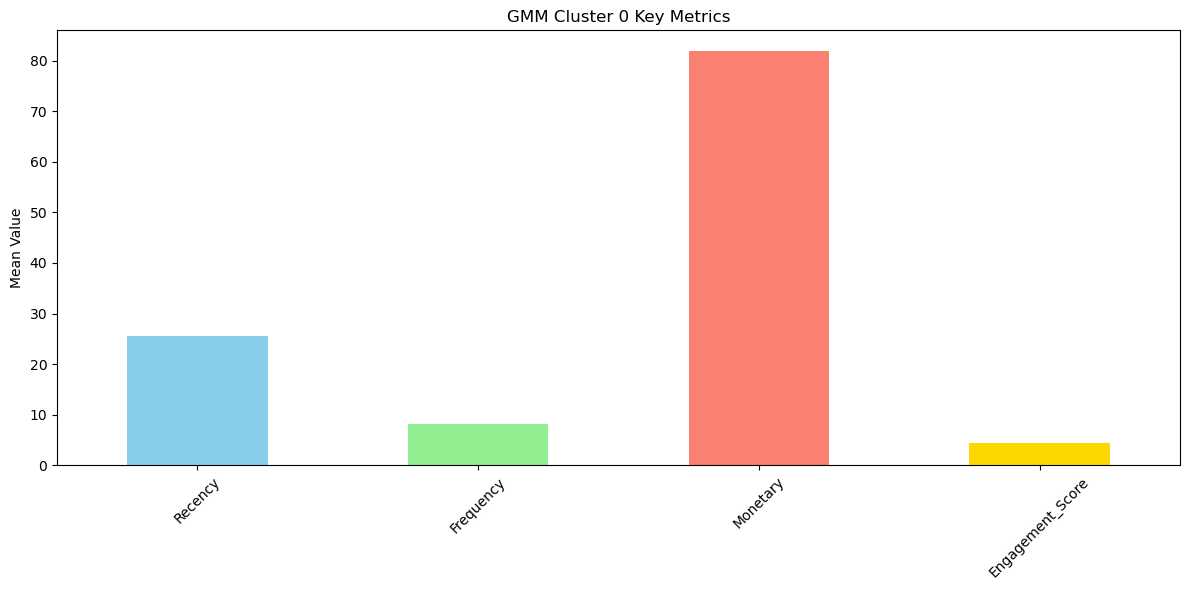

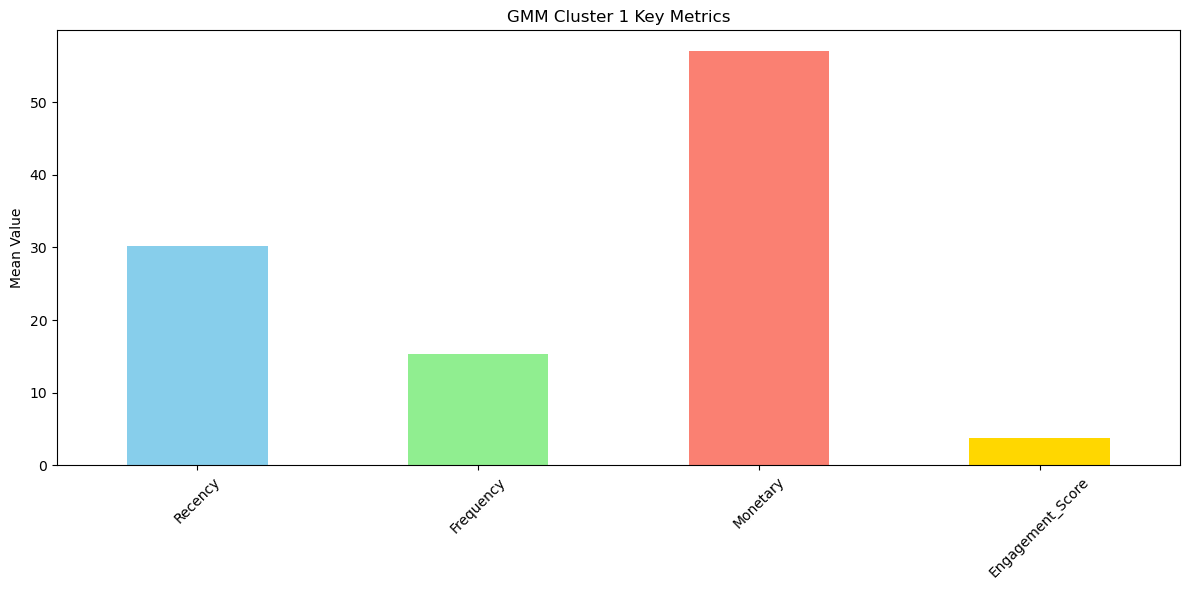

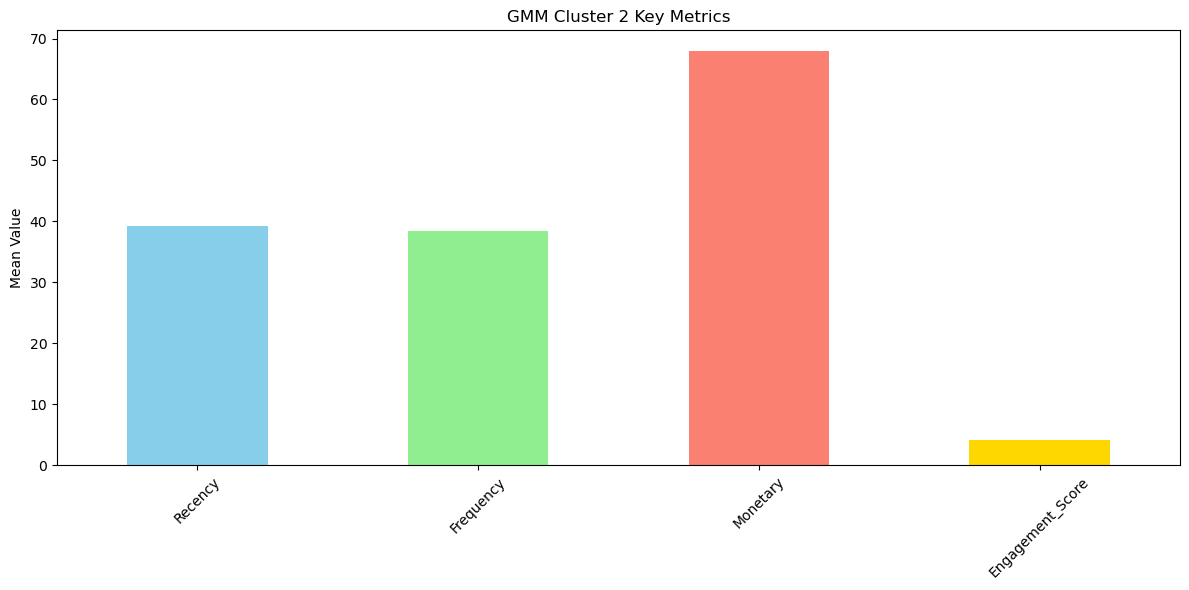

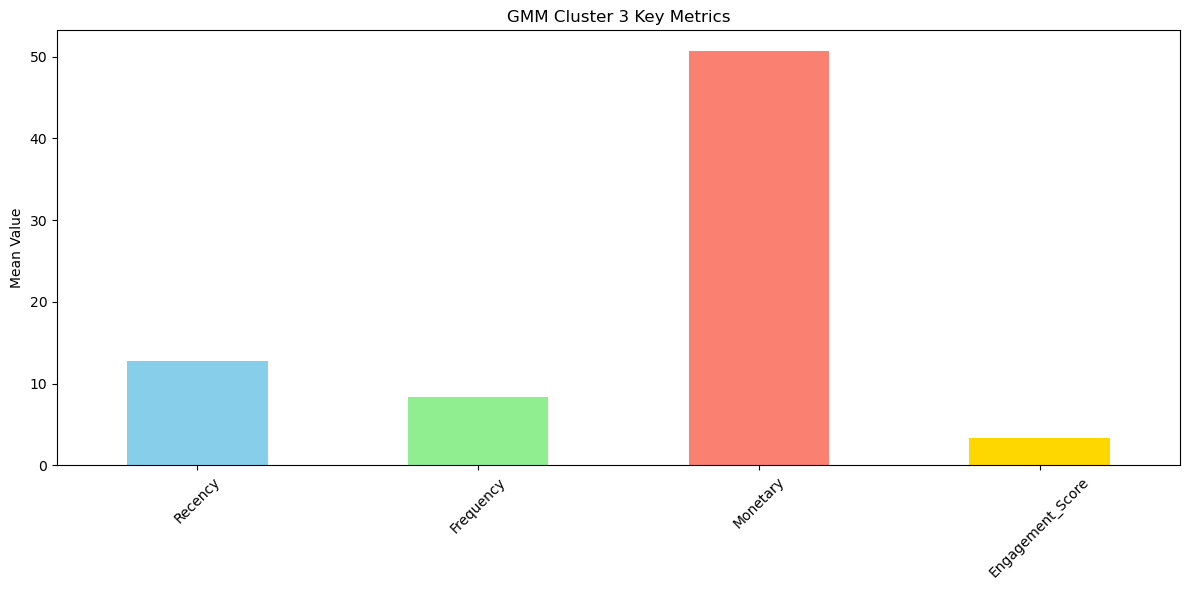

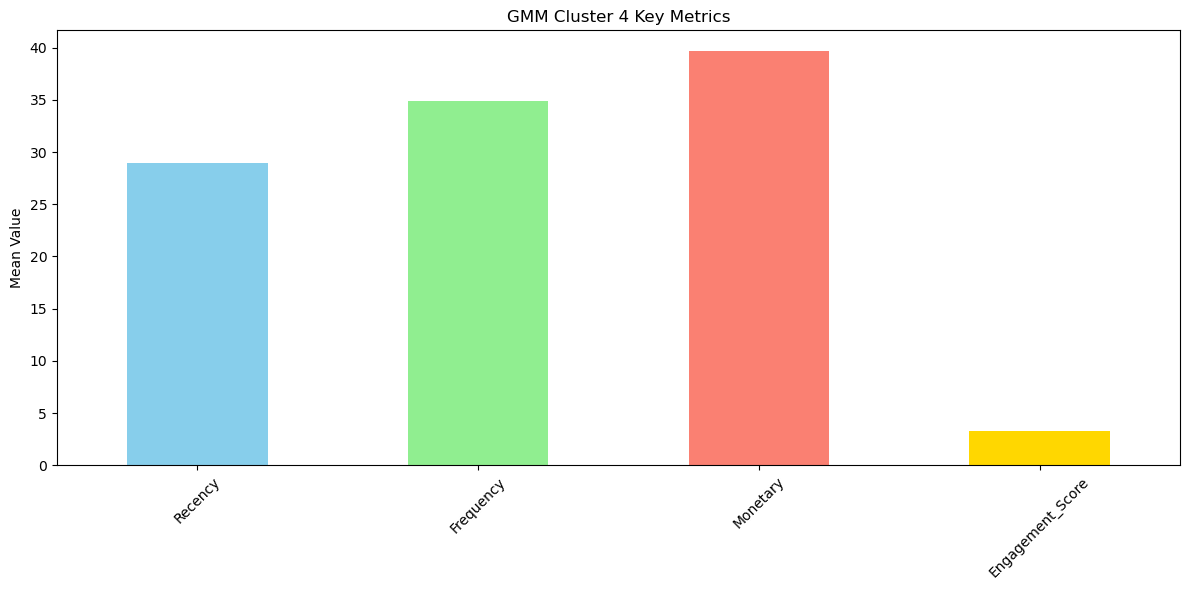

In [40]:
# Cluster 0 key metrics from GMM
plt.figure(figsize=(12, 6))
segment_data = df_gmm[df_gmm["GMM_Cluster"] == 0]
segment_data_mean = segment_data[features_gmm].mean()
colors = ["skyblue", "lightgreen", "salmon", "gold"]
segment_data_mean.plot(kind="bar", color=colors)
plt.title("GMM Cluster 0 Key Metrics")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cluster 1
plt.figure(figsize=(12, 6))
segment_data = df_gmm[df_gmm["GMM_Cluster"] == 1]
segment_data_mean = segment_data[features_gmm].mean()
colors = ["skyblue", "lightgreen", "salmon", "gold"]
segment_data_mean.plot(kind="bar", color=colors)
plt.title("GMM Cluster 1 Key Metrics")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cluster 2 
plt.figure(figsize=(12, 6))
segment_data = df_gmm[df_gmm["GMM_Cluster"] == 2]
segment_data_mean = segment_data[features_gmm].mean()
colors = ["skyblue", "lightgreen", "salmon", "gold"]
segment_data_mean.plot(kind="bar", color=colors)
plt.title("GMM Cluster 2 Key Metrics")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cluster 3
plt.figure(figsize=(12, 6))
segment_data = df_gmm[df_gmm["GMM_Cluster"] == 3]
segment_data_mean = segment_data[features_gmm].mean()
colors = ["skyblue", "lightgreen", "salmon", "gold"]
segment_data_mean.plot(kind="bar", color=colors)
plt.title("GMM Cluster 3 Key Metrics")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Cluster 4
plt.figure(figsize=(12, 6))
segment_data = df_gmm[df_gmm["GMM_Cluster"] == 4]
segment_data_mean = segment_data[features_gmm].mean()
colors = ["skyblue", "lightgreen", "salmon", "gold"]
segment_data_mean.plot(kind="bar", color=colors)
plt.title("GMM Cluster 4 Key Metrics")
plt.ylabel("Mean Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [41]:
print("\n--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS BASED ON GMM ---")

segment_descriptions = {
    "Low Engagement Browser": "Customers who browse occasionally but rarely convert to significant purchases.",
    "Moderate Value Loyal": "Customers with medium recency, frequency, and monetary values, showing good engagement. Solid middle-tier customers.",
    "High-Value Premium": "Premium customers with high monetary value, regular purchases, and good recency/frequency metrics.",
    "Recent Low-Value Explorer": "Newer customers who have made recent purchases but at a lower monetary value. They may be exploring the brand.",
    "Occasional Big Spender": "Customers who shop infrequently but spend significantly when they do."
}

marketing_recommendations = {
    "Low Engagement Browser": [
        "Implement targeted email campaigns to re-engage these customers",
        "Use retargeting ads to remind them of past views and interests",
        "Offer exclusive first-time purchase discounts",
        "Test interactive content such as quizzes to understand their interests",
        "Incentivize small initial purchases with limited-time offers"
    ],
    "Moderate Value Loyal": [
        "Develop a rewards program with tiered benefits to enhance loyalty",
        "Offer personalized recommendations based on past purchases",
        "Provide special early-access to new product launches",
        "Encourage referrals with discounts or perks",
        "Send engagement-driven content such as styling tips, usage guides, etc."
    ],
    "High-Value Premium": [
        "Create an exclusive VIP membership program with premium perks",
        "Provide white-glove customer service and personal shopping assistance",
        "Offer invitation-only events and product pre-orders",
        "Bundle high-end products with exclusive limited-time collections",
        "Highlight brand values and storytelling in marketing materials"
    ],
    "Recent Low-Value Explorer": [
        "Implement a nurturing email series introducing product benefits",
        "Encourage repeat purchases with 'next purchase' incentives",
        "Use social proof (reviews, testimonials) to build trust",
        "Showcase best-selling items in follow-up marketing campaigns",
        "Offer personalized first-purchase discounts to increase retention"
    ],
    "Occasional Big Spender": [
        "Send personalized high-end product recommendations",
        "Offer concierge-style services to enhance the shopping experience",
        "Provide targeted promotions around peak spending periods",
        "Introduce high-value loyalty perks for large purchase sizes",
        "Encourage category expansion with curated bundles"
    ]
}


--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS BASED ON GMM ---


In [42]:
product_strategies = {
    "Low Engagement Browser": "Highlight entry-level products, bestsellers, and accessible price points.",
    "Moderate Value Loyal": "Offer personalized product bundles and exclusive early access to promotions.",
    "High-Value Premium": "Showcase luxury items, premium collections, and exclusive limited-edition products.",
    "Recent Low-Value Explorer": "Promote starter sets, introductory offers, and educational product content.",
    "Occasional Big Spender": "Feature high-ticket items, exclusive bundles, and premium experience-driven products."
}

# Updated function to handle unknown segments with GMM-based logic
def get_generic_description(segment_name):
    if "Low Engagement" in segment_name or "Browser" in segment_name:
        return segment_descriptions["Low Engagement Browser"]
    elif "Moderate" in segment_name or "Loyal" in segment_name:
        return segment_descriptions["Moderate Value Loyal"]
    elif "High-Value" in segment_name or "Premium" in segment_name:
        return segment_descriptions["High-Value Premium"]
    elif "Recent" in segment_name or "Explorer" in segment_name:
        return segment_descriptions["Recent Low-Value Explorer"]
    elif "Occasional" in segment_name or "Big Spender" in segment_name:
        return segment_descriptions["Occasional Big Spender"]
    else:
        return "Customers with specific shopping patterns and preferences."

def get_generic_recommendations(segment_name):
    if "Low Engagement" in segment_name or "Browser" in segment_name:
        return marketing_recommendations["Low Engagement Browser"]
    elif "Moderate" in segment_name or "Loyal" in segment_name:
        return marketing_recommendations["Moderate Value Loyal"]
    elif "High-Value" in segment_name or "Premium" in segment_name:
        return marketing_recommendations["High-Value Premium"]
    elif "Recent" in segment_name or "Explorer" in segment_name:
        return marketing_recommendations["Recent Low-Value Explorer"]
    elif "Occasional" in segment_name or "Big Spender" in segment_name:
        return marketing_recommendations["Occasional Big Spender"]
    else:
        return [
            "Test various engagement strategies to refine segmentation",
            "Develop targeted outreach campaigns to drive conversions",
            "Analyze buying behavior for deeper insights into shopping patterns",
            "Implement automated re-engagement emails and promotions",
            "Create A/B tests for personalized product recommendations"
        ]

def get_generic_product_strategy(segment_name):
    if "Low Engagement" in segment_name or "Browser" in segment_name:
        return product_strategies["Low Engagement Browser"]
    elif "Moderate" in segment_name or "Loyal" in segment_name:
        return product_strategies["Moderate Value Loyal"]
    elif "High-Value" in segment_name or "Premium" in segment_name:
        return product_strategies["High-Value Premium"]
    elif "Recent" in segment_name or "Explorer" in segment_name:
        return product_strategies["Recent Low-Value Explorer"]
    elif "Occasional" in segment_name or "Big Spender" in segment_name:
        return product_strategies["Occasional Big Spender"]
    else:
        return "Refine product recommendations based on customer behavior and purchase history."

In [43]:
# Generate segment insights and marketing recommendations
print("\n--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---")

for cluster, segment_name in segment_names.items():
    segment_data = df[df['Cluster'] == cluster]
    count = len(segment_data)
    pct = count / len(df) * 100

    print(f"\n=== {segment_name} ===")
    print(f"Size: {count} customers ({pct:.1f}% of total customers)")
    
    # Calculate key metrics
    avg_purchase = segment_data['Purchase Amount (USD)'].mean()
    freq_counts = segment_data['Frequency of Purchases'].value_counts().nlargest(2)
    avg_previous = segment_data['Previous Purchases'].mean()
    avg_rating = segment_data['Review Rating'].mean()
    discount_usage = (segment_data['Discount Applied'] == 'Yes').mean() * 100
    promo_usage = (segment_data['Promo Code Used'] == 'Yes').mean() * 100
    subscription_rate = (segment_data['Subscription Status'] == 'Yes').mean() * 100

    # Top categories and products
    top_categories = segment_data['Category'].value_counts().nlargest(2)
    top_items = segment_data['Item Purchased'].value_counts().nlargest(3)
    top_seasons = segment_data['Season'].value_counts().nlargest(2)
    top_colors = segment_data['Color'].value_counts().nlargest(3)
    
    # Print segment profile
    print("\nKEY CHARACTERISTICS:")
    print(f"• Average purchase: ${avg_purchase:.2f}")
    print(f"• Purchase frequency: {', '.join([f'{freq} ({count})' for freq, count in freq_counts.items()])}")
    print(f"• Previous purchases: {avg_previous:.1f}")
    print(f"• Average rating: {avg_rating:.1f}/5")
    print(f"• Discount usage: {discount_usage:.1f}%")
    print(f"• Promo code usage: {promo_usage:.1f}%")
    print(f"• Subscription rate: {subscription_rate:.1f}%")
    
    print("\nPRODUCT PREFERENCES:")
    print("• Top categories:")
    for cat, count in top_categories.items():
        print(f"  - {cat}: {count} purchases ({count/len(segment_data)*100:.1f}% of segment)")
    
    print("• Top items:")
    for item, count in top_items.items():
        print(f"  - {item}: {
            count} purchases")
        
    print("• Top seasons:")
    for season, count in top_seasons.items():
        print(f"  - {season}: {count} purchases")

    print("• Top colors:")
    for color, count in top_colors.items():
        print(f"  - {color}: {count} purchases")
    
    # Segment-specific recommendations
    print("\nMARKETING RECOMMENDATIONS:")
    print(get_generic_description(segment_name))
    print(get_generic_recommendations(segment_name))
    print("\nPRODUCT STRATEGY:")
    print(get_generic_product_strategy(segment_name))


--- SEGMENT PROFILES & MARKETING RECOMMENDATIONS ---

=== High-Value Loyal Customer ===
Size: 405 customers (10.4% of total customers)

KEY CHARACTERISTICS:
• Average purchase: $39.65
• Purchase frequency: Fortnightly (75), Every 3 Months (72)
• Previous purchases: 35.9
• Average rating: 4.3/5
• Discount usage: 43.2%
• Promo code usage: 43.2%
• Subscription rate: 0.0%

PRODUCT PREFERENCES:
• Top categories:
  - Clothing: 169 purchases (41.7% of segment)
  - Accessories: 137 purchases (33.8% of segment)
• Top items:
  - Jewelry: 31 purchases
  - Blouse: 26 purchases
  - Gloves: 24 purchases
• Top seasons:
  - Spring: 106 purchases
  - Summer: 102 purchases
• Top colors:
  - Silver: 23 purchases
  - Turquoise: 23 purchases
  - Teal: 23 purchases

MARKETING RECOMMENDATIONS:
Customers with medium recency, frequency, and monetary values, showing good engagement. Solid middle-tier customers.
['Develop a rewards program with tiered benefits to enhance loyalty', 'Offer personalized recommenda

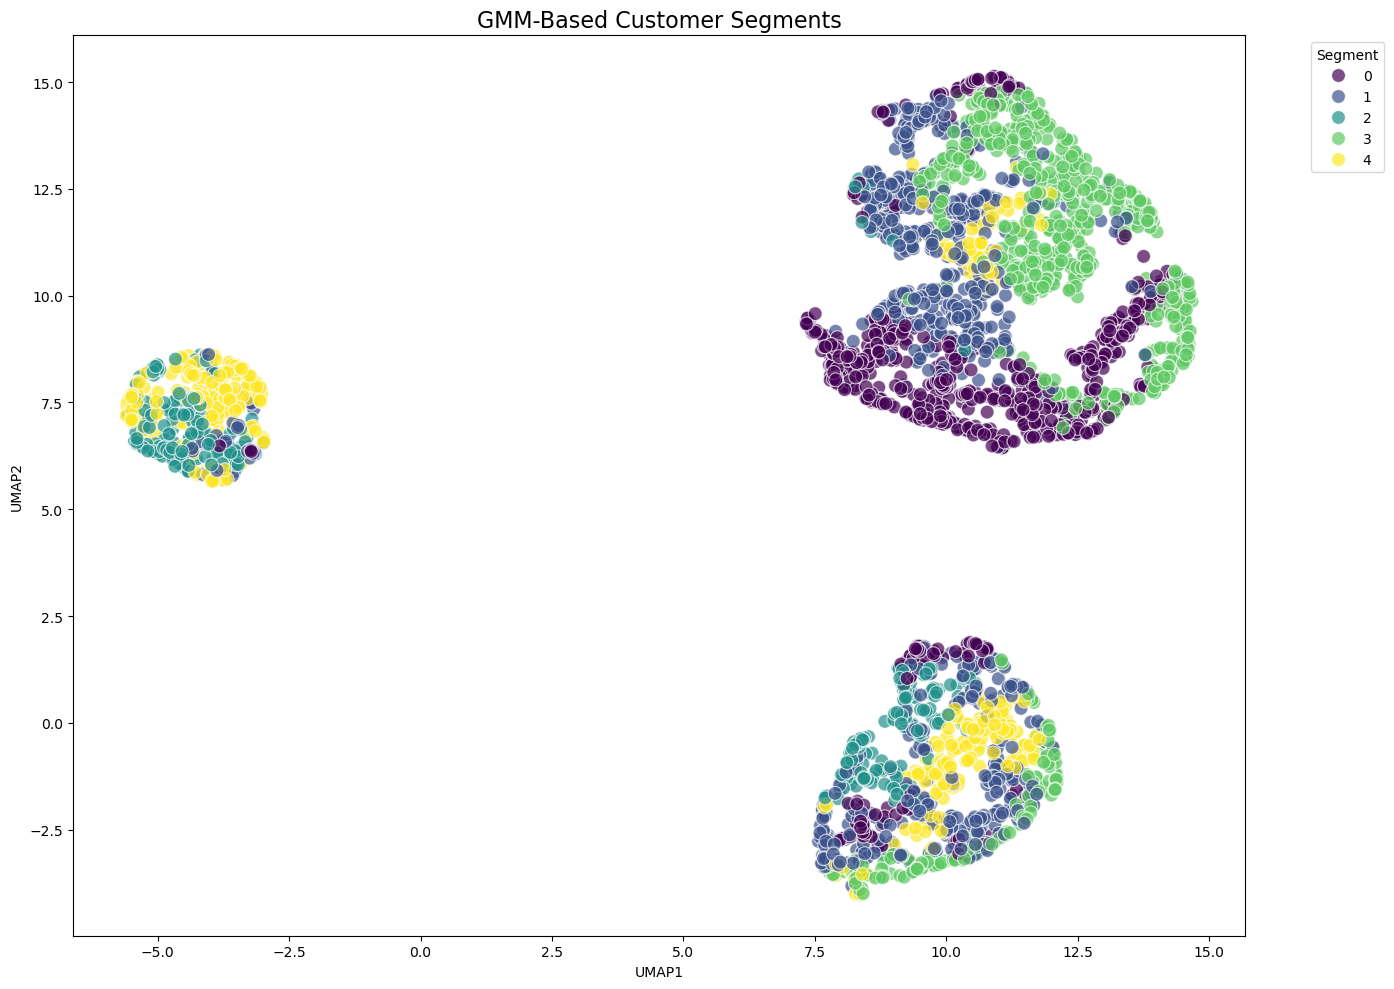

In [44]:
# Add UMAP1 and UMAP2 columns to df_gmm
df_gmm['UMAP1'] = viz_embedding[:, 0]
df_gmm['UMAP2'] = viz_embedding[:, 1]

# Visualize the GMM clusters
plt.figure(figsize=(14, 10))
sns.scatterplot(
    data=df_gmm,
    x='UMAP1',
    y='UMAP2',
    hue='GMM_Cluster',
    palette='viridis',
    s=100,
    alpha=0.7
)
plt.title('GMM-Based Customer Segments', fontsize=16)
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()